# HAR class-incremental continual learning
## A comparison between two replay methods

In this notebook I am going to present some methods to adress the problem of class incremental leaning i.e. the challenge that a model pretrained on a fixed number of classes faces when learning a new class. The challenge stands in the fact that such model should be able to learn from the new stream of data while being able to retain the old knowledge.

The field of application of such CL techniques is the one of Human Activity Recognition and the dataset used is the following:

Logacjov,Aleksej, Kongsvold,Atle, Bach,Kerstin, Bårdstu,Hilde Bremseth, and Mork,Paul Jarle. (2023). HARTH. UCI Machine Learning Repository. https://doi.org/10.24432/C5NC90.

Twenty-two participants performed different activities during their regular working hours while carrying out their everyday activities as naturally as possible. Two experts annotated twelve activities in total. Two
accelerometers where placed on the thigh and lower back of the subjects to collect sensor data.

# Data pre-processing

### Exploratory data analysis




Let's start by importing some useful libraries, connecting google drive and loading the dataset.


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
project_path =  "/content/drive/MyDrive/ColabData/AmID/replay"

Mounted at /content/drive


In [ ]:
!wget https://www.archive-beta.ics.uci.edu/static/public/779/harth.zip --no-check-certificate

--2023-11-05 14:11:23--  https://www.archive-beta.ics.uci.edu/static/public/779/harth.zip
Resolving www.archive-beta.ics.uci.edu (www.archive-beta.ics.uci.edu)... 128.195.216.160
Connecting to www.archive-beta.ics.uci.edu (www.archive-beta.ics.uci.edu)|128.195.216.160|:443... ^C


In [ ]:
!unzip harth.zip

unzip:  cannot find or open harth.zip, harth.zip.zip or harth.zip.ZIP.


In [ ]:
!unzip 1676986373282-102581039harth.zip

Let's map each activity ID to the correponding activity label.

In [ ]:
activities_map = {
    "1": "walking",
    "2": "running",
    "3": "shuffling",
    "4": "stairs (ascending)",
    "5": "stairs (descending)",
    "6": "standing",
    "7": "sitting",
    "8": "lying",
    "13": "cycling (sit)",
    "14": "cycling (stand)",
    "130": "cycling (sit, inactive)",
    "140": "cycling (stand, inactive)"
}

Here we will have an overview of the distribution of the dataset's activities: the goal is to see if the dataset is balanced in terms of samples for activity and if the amount of data coming from different subjects is uniform.

In [ ]:
acts_dict = {str(i):0 for i in [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 130, 140]}
subjects_dict = {i:0 for i in range(6, 30) if i not in [7, 11]}

for subject in subjects_dict.keys():
  if subject < 10:
      with open(f"harth/S00{subject}.csv", "r") as f:
        next(f) #skip the first line of each file = header
        print(f"Subject {subject}...", end="")

        for line in f:
          line = line.split(",")
          act_id = line[7].strip() #here remove \n after label
          acts_dict[act_id] += 1
          subjects_dict[subject] += 1

        print("done")
  else:
      with open(f"harth/S0{subject}.csv", "r") as f:
          next(f) #skip the first line of each file = header
          print(f"Subject {subject}...", end="")

          for line in f:
            line = line.split(",")
            if subject in [15, 21, 23]: act_id = line[8].strip()  #here remove \n after label + 2 subjects have an extra column (later in the code is shown better)
            else: act_id = line[7].strip()
            acts_dict[act_id] += 1
            subjects_dict[subject] += 1

          print("done")
print()
acts_dict = {activities_map[k]:v for k,v in acts_dict.items()}
print(acts_dict)
print(subjects_dict)

Subject 6...done
Subject 8...done
Subject 9...done
Subject 10...done
Subject 12...done
Subject 13...done
Subject 14...done
Subject 15...done
Subject 16...done
Subject 17...done
Subject 18...done
Subject 19...done
Subject 20...done
Subject 21...done
Subject 22...done
Subject 23...done
Subject 24...done
Subject 25...done
Subject 26...done
Subject 27...done
Subject 28...done
Subject 29...done

{'walking': 1197155, 'running': 291356, 'shuffling': 254839, 'stairs (ascending)': 76217, 'stairs (descending)': 67253, 'standing': 743480, 'sitting': 2902703, 'lying': 428898, 'cycling (sit)': 393963, 'cycling (stand)': 55814, 'cycling (sit, inactive)': 41785, 'cycling (stand, inactive)': 7865}
{6: 408709, 8: 418989, 9: 154464, 10: 351649, 12: 382414, 13: 369077, 14: 366487, 15: 418392, 16: 355418, 17: 366609, 18: 322271, 19: 297945, 20: 371496, 21: 302247, 22: 337602, 23: 137646, 24: 170534, 25: 231729, 26: 195172, 27: 158584, 28: 165178, 29: 178716}


#### Distribution of data based on activity labels

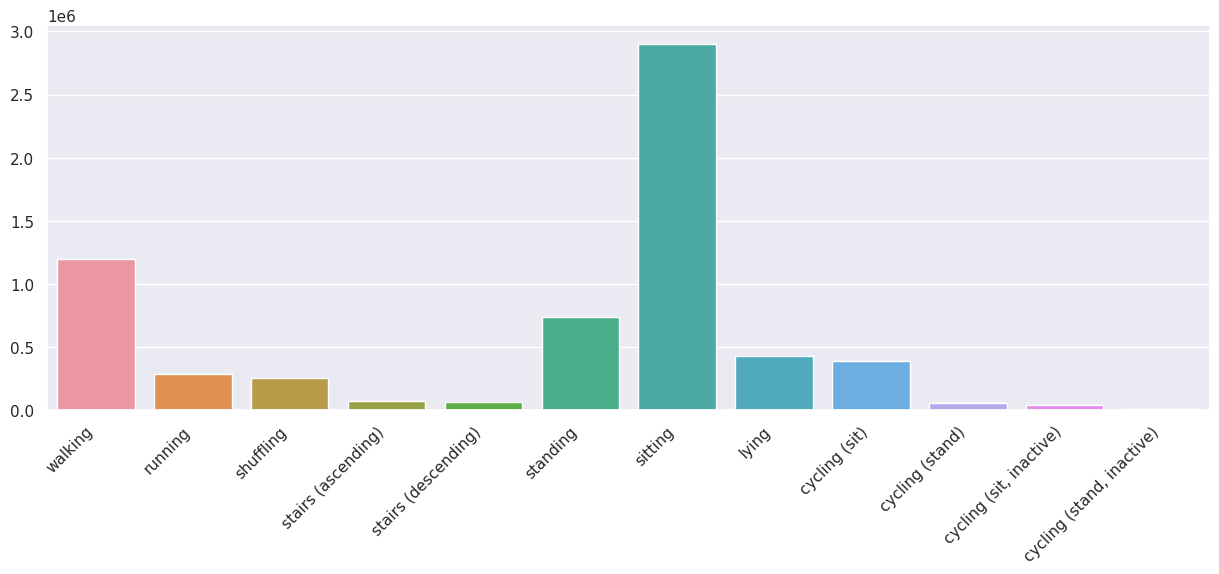

In [ ]:
sns.set(rc={'figure.figsize':(15,5)})
sns.barplot(x=list(acts_dict.keys()), y=list(acts_dict.values()))
plt.xticks(rotation=45, ha='right')  # ha = horizontal alignment
plt.show()

The distribution of the labels, as predictable, is not uniform: this is due to the fact that these measuraments come from (monitored) real life scenarios. Class-imbalance could make training relaiable models harder.

In order to slightly reduce class imbalance we can aggregate some classes, as they regard similar activities. This is also suggested by the paper describing HARTH dataset.

In particular let's group together:
* standing and shuffling (stepping in place by non-cyclical and non-directional movement of the feet): will be labeled as standing
* cycling (sit) and cycling (sit, inactive): will be labeled as cycling (sit)
* cycling (stand) and cycling (stand, inactive): will be labeled as cycling (stand)

Another problem regards the class "sitting" for which the samples are more than double with respect to the ones of other classes. This problem will be adressed simply by randomly selecting a percentage of data from this class. I have chosen to pick 43% of such data in order to have a similar number of samples to the next largest class, walking.

Both of these operations (grouping some classes and reducting the number of "sitting" data) will be done later on in the notebook.

#### Distribution of data based on subject

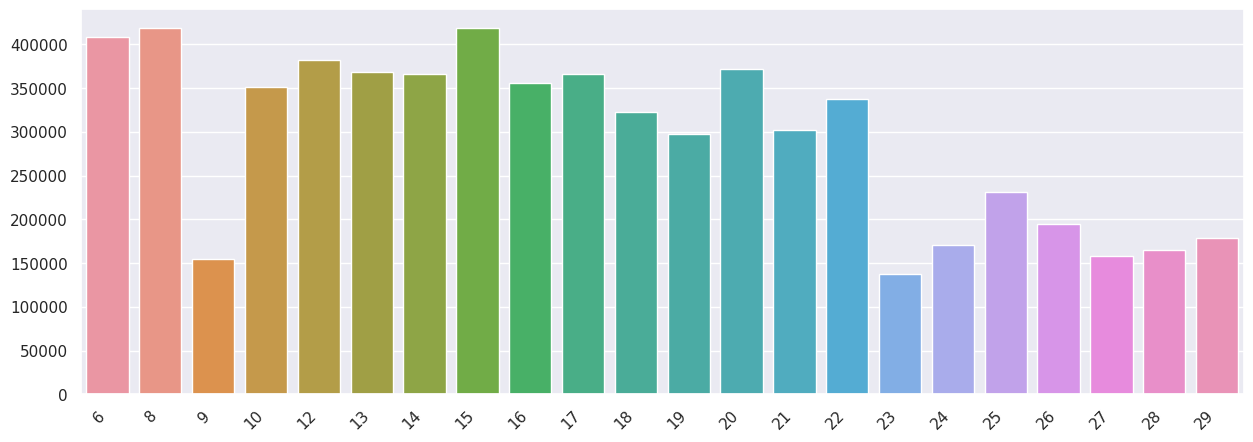

In [ ]:
sns.barplot(x=list(subjects_dict.keys()), y=list(subjects_dict.values()))
plt.xticks(rotation=45, ha='right')
plt.show()

Unfortunately, collected data is also not uniform in term of subject performing the actvities.

Let's now inspect the distribution of different activities within different subjects: if it is far from being uniform then evaluating models with subject-specific metrics won't be feasibile.


In [ ]:
acts_dict = {str(i):0 for i in [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 130, 140]}
subjects_dict = {i:dict(acts_dict) for i in range(6, 30) if i not in [7, 11]}

for subject in subjects_dict.keys():
  if subject < 10:
      with open(f"harth/S00{subject}.csv", "r") as f:
        next(f) #skip the first line of each file = header
        print(f"Subject {subject}...", end="")

        for line in f:
          line = line.split(",")
          act_id = line[7].strip() #here remove \n after label
          subjects_dict[subject][act_id] += 1

        subjects_dict[subject] = {activities_map[k]:v for k,v in subjects_dict[subject].items()}
        print(subjects_dict[subject])
  else:
      with open(f"harth/S0{subject}.csv", "r") as f:
          next(f) #skip the first line of each file = header
          print(f"Subject {subject}...", end="")

          for line in f:
            line = line.split(",")
            if subject in [15, 21, 23]: act_id = line[8].strip()  #here remove \n after label + 2 subjects have an extra column
            else: act_id = line[7].strip()
            acts_dict[act_id] += 1
            subjects_dict[subject][act_id] += 1

          subjects_dict[subject] = {activities_map[k]:v for k,v in subjects_dict[subject].items()}
          print(subjects_dict[subject])

Subject 6...{'walking': 24889, 'running': 0, 'shuffling': 12693, 'stairs (ascending)': 1370, 'stairs (descending)': 1550, 'standing': 62682, 'sitting': 253029, 'lying': 13036, 'cycling (sit)': 25040, 'cycling (stand)': 3130, 'cycling (sit, inactive)': 11290, 'cycling (stand, inactive)': 0}
Subject 8...{'walking': 21454, 'running': 0, 'shuffling': 28827, 'stairs (ascending)': 708, 'stairs (descending)': 750, 'standing': 65222, 'sitting': 292812, 'lying': 0, 'cycling (sit)': 7548, 'cycling (stand)': 748, 'cycling (sit, inactive)': 170, 'cycling (stand, inactive)': 750}
Subject 9...{'walking': 5676, 'running': 0, 'shuffling': 178, 'stairs (ascending)': 448, 'stairs (descending)': 560, 'standing': 6080, 'sitting': 0, 'lying': 0, 'cycling (sit)': 120101, 'cycling (stand)': 10926, 'cycling (sit, inactive)': 10375, 'cycling (stand, inactive)': 120}
Subject 10...{'walking': 175910, 'running': 0, 'shuffling': 29738, 'stairs (ascending)': 5958, 'stairs (descending)': 3422, 'standing': 90175, 'si

In [ ]:
df = pd.DataFrame(subjects_dict)
df

,6,8,9,10,12,13,14,15,16,17,...,20,21,22,23,24,25,26,27,28,29
walking,24889,21454,5676,175910,12958,34548,28086,55022,39298,35944,...,35120,47896,73030,70601,79000,66578,25096,2954,147858,121460
running,0,0,0,0,2198,3494,2490,2946,2806,5138,...,3740,3760,2334,22391,26732,34212,11504,131307,0,17774
shuffling,12693,28827,178,29738,7192,37316,18514,12000,17008,9363,...,7572,7269,16970,2071,3308,7134,3282,1724,2081,5702
stairs (ascending),1370,708,448,5958,4320,3440,5066,7066,316,8152,...,3018,3354,5282,3194,3306,4070,7087,0,1056,386
stairs (descending),1550,750,560,3422,2772,2846,4428,6626,2392,6088,...,2374,1658,4976,2291,2974,2746,9394,104,1316,936
standing,62682,65222,6080,90175,22360,53591,56331,67302,52824,30971,...,19974,40388,59572,7455,10488,14564,3919,1629,8475,12177
sitting,253029,292812,0,46446,311722,223424,236582,195040,189796,217892,...,236956,168266,140704,13059,13864,8644,4542,9762,2740,3406
lying,13036,0,0,0,18892,7554,9420,63332,39966,44068,...,46952,26762,19282,16584,30862,20262,0,11104,1652,4842
cycling (sit),25040,7548,120101,0,0,2764,5570,7268,10474,4672,...,14550,2372,13217,0,0,52593,97600,0,0,10443
cycling (stand),3130,748,10926,0,0,0,0,1790,288,3101,...,570,522,0,0,0,12946,20298,0,0,0


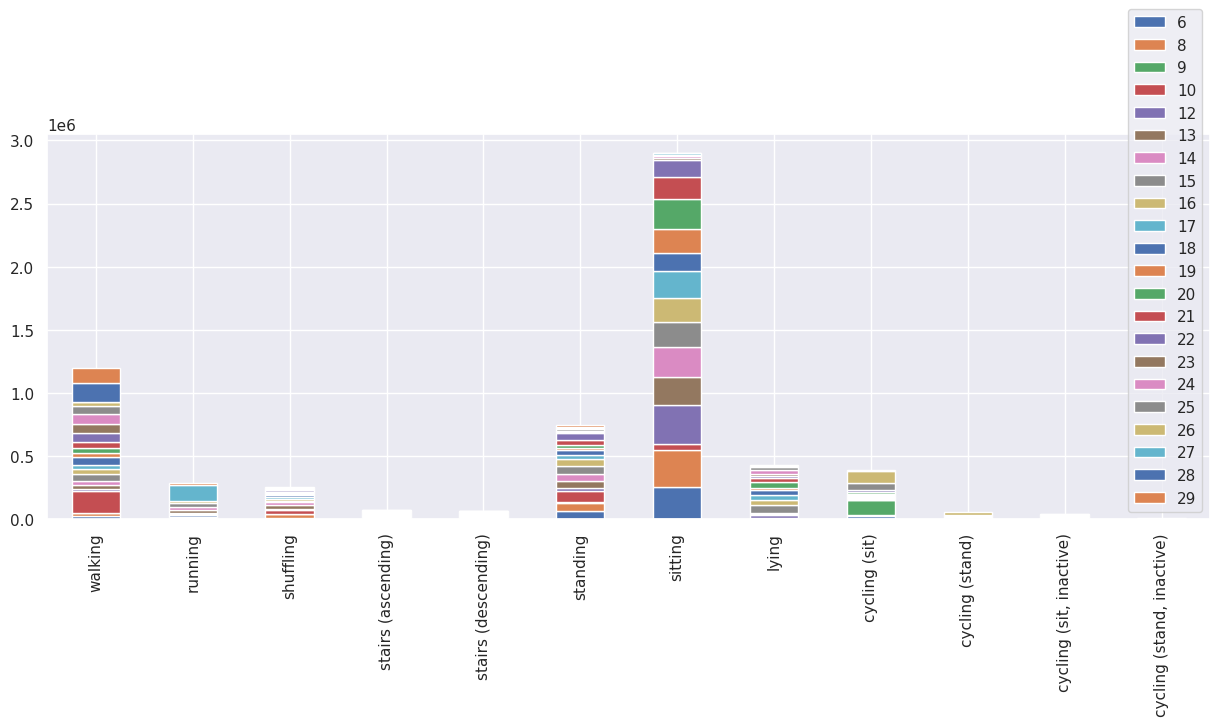

In [ ]:
df.plot(kind='bar', stacked=True)
plt.show()

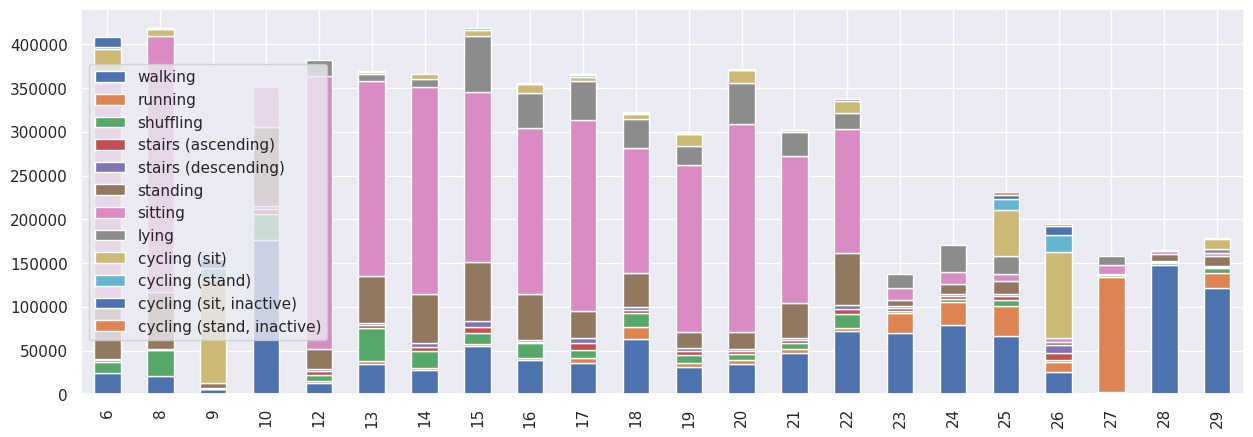

In [ ]:
transposed_df = df.T

transposed_df.plot(kind='bar', stacked=True)
plt.show()

In this graph it is evident that not all subjects performed the same activities: this is due to the fact that the HARTH dataset was collected in two sessions, and in the second one subjects were asked to perform mainly "active" activities.

To simplify the project I have decided to ignore the subject-dependancy of data and consider the collected data as if it was collected from a single, general subject. Obviously this is not ideal, as different people have different ways of performing the same activity; but this is partially mitigated by standardizing all sensor data windows (see later).


### Data cleaning

Looking through the collected data I have noticed how, for the first subject, the difference between consecutive timestamps is of 0.01s and not of 0.02s as expected by the stated sampling rate of 50Hz. Also, between the first and the 50-th sample, 0.5s have passed and not 1s.

In [ ]:
df = pd.read_csv(f"harth/S006.csv", sep=',', header=0, engine='python') #load data of the first subject (= subject 6)
df

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6
1,2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6
2,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6
3,2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6
4,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6
...,...,...,...,...,...,...,...,...
408704,2019-01-12 01:09:32.880,-0.690417,0.035710,-0.697054,0.228261,0.072950,0.985175,7
408705,2019-01-12 01:09:32.890,-0.745270,0.032438,-0.681320,-0.121986,0.063700,1.026665,7
408706,2019-01-12 01:09:32.900,-0.684827,0.037622,-0.703884,0.302960,0.076986,0.978313,7
408707,2019-01-12 01:09:32.910,-0.751518,0.028819,-0.668037,-0.241803,0.056675,1.026166,7


Let's perform downsampling: data of subject 6 was sampled at 100Hz, we want to switch to 50Hz, i.e. the same sampling frequency of all other data.

To use the "resample" function it's necessary to set the timestamp as the index of the dataframe.

In [ ]:
tmp_df = df.copy()
tmp_df['timestamp']=pd.to_datetime(tmp_df['timestamp'], errors ='coerce')
tmp_df = tmp_df.set_index('timestamp')
tmp_df

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
timestamp,,,,,,,
2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6
2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6
2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6
2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6
2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6
...,...,...,...,...,...,...,...
2019-01-12 01:09:32.880,-0.690417,0.035710,-0.697054,0.228261,0.072950,0.985175,7
2019-01-12 01:09:32.890,-0.745270,0.032438,-0.681320,-0.121986,0.063700,1.026665,7
2019-01-12 01:09:32.900,-0.684827,0.037622,-0.703884,0.302960,0.076986,0.978313,7


The wanted frequency is 50Hz which corresponds to collecting a measurament every 1/50 seconds = 20 milliseconds. I also used the backward and forward fill in order to fix the first and last timestamp.

In [ ]:
tmp_df = tmp_df.resample('20L').bfill().ffill()
tmp_df = tmp_df.reset_index()
tmp_df

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6
1,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6
2,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6
3,2019-01-12 00:00:00.060,-1.187088,-0.005508,0.056683,-0.520771,0.154755,-0.232140,6
4,2019-01-12 00:00:00.080,-0.841369,0.129879,0.122489,-0.954652,-0.293586,-0.184660,6
...,...,...,...,...,...,...,...,...
208642,2019-01-12 01:09:32.840,-0.697368,0.034544,-0.692974,0.167349,0.070379,0.998739,7
208643,2019-01-12 01:09:32.860,-0.694453,0.034960,-0.694389,0.190412,0.071246,0.988794,7
208644,2019-01-12 01:09:32.880,-0.690417,0.035710,-0.697054,0.228261,0.072950,0.985175,7
208645,2019-01-12 01:09:32.900,-0.684827,0.037622,-0.703884,0.302960,0.076986,0.978313,7


Let's substitute this new, downsampled, version of data from subject 6 to its original data.

In [ ]:
tmp_df.to_csv(f"harth/S006.csv", sep=',', mode='w', index = False)

In [ ]:
df = pd.read_csv(f"harth/S006.csv", sep=',', header=0, engine='python') # re-load same file

In [ ]:
df # check data

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6
1,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6
2,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6
3,2019-01-12 00:00:00.060,-1.187088,-0.005508,0.056683,-0.520771,0.154755,-0.232140,6
4,2019-01-12 00:00:00.080,-0.841369,0.129879,0.122489,-0.954652,-0.293586,-0.184660,6
...,...,...,...,...,...,...,...,...
208642,2019-01-12 01:09:32.840,-0.697368,0.034544,-0.692974,0.167349,0.070379,0.998739,7
208643,2019-01-12 01:09:32.860,-0.694453,0.034960,-0.694389,0.190412,0.071246,0.988794,7
208644,2019-01-12 01:09:32.880,-0.690417,0.035710,-0.697054,0.228261,0.072950,0.985175,7
208645,2019-01-12 01:09:32.900,-0.684827,0.037622,-0.703884,0.302960,0.076986,0.978313,7


Now let's check if this anomalous behaviuor is present only in subject 6 (which is the one considred above) or if there are other subjects with the same problem.

In [ ]:
for subject in subjects_dict.keys():
  if subject < 10:
    df = pd.read_csv(f"harth/S00{subject}.csv", sep=',', header=0, engine='python')
    print(f"Subject {subject}....", end="")
    print(df['timestamp'][0], df['timestamp'][50]) # print the first and the 50-th timestamp: difference should be of 1 second
  else:
    df = pd.read_csv(f"harth/S0{subject}.csv", sep=',', header=0, engine='python')
    print(f"Subject {subject}...", end="")
    print(df['timestamp'][0], df['timestamp'][50])

Subject 6....2019-01-12 00:00:00.000 2019-01-12 00:00:01.000
Subject 8....2019-01-12 00:00:00.000 2019-01-12 00:00:01.000
Subject 9....2000-01-01 00:00:00.000 2000-01-01 00:00:01.000
Subject 10...2019-01-12 00:00:00.000 2019-01-12 00:00:01.000
Subject 12...2000-01-01 00:00:00.000 2000-01-01 00:00:01.000
Subject 13...2000-01-01 00:00:00.000 2000-01-01 00:00:01.000
Subject 14...2000-01-01 00:00:00.000 2000-01-01 00:00:01.000
Subject 15...2019-01-12 00:00:00.000 2019-01-12 00:00:01.000
Subject 16...2019-01-12 00:00:00.000 2019-01-12 00:00:01.000
Subject 17...2000-01-01 00:00:00.000 2000-01-01 00:00:01.000
Subject 18...2000-01-01 00:00:00.000 2000-01-01 00:00:01.000
Subject 19...2019-01-12 00:00:00.000 2019-01-12 00:00:01.000
Subject 20...2016-12-05 13:17:56.548657565 2016-12-05 13:17:57.548657315
Subject 21...2019-01-12 00:00:00.000 2019-01-12 00:00:02.120
Subject 22...2000-01-01 00:00:00.000 2000-01-01 00:00:01.000
Subject 23...2019-01-12 00:00:00.000 2019-01-12 00:00:01.000
Subject 24..

Notice how the data recorded from the 20-th subject also has a few problems: this is probably due to the precision of the clock used, as the time difference between the two printed timestamps is almost one second. It is only a matter of making the date time format coherent with the rest; this can be done in a simple way by exploiting once again the resampling function.

In [ ]:
df = pd.read_csv(f"harth/S020.csv", sep=',', header=0, engine='python') # load data from subject 20
df

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2016-12-05 13:17:56.548657565,-1.019405,0.058278,-0.090941,-0.916962,0.004126,-0.198709,6
1,2016-12-05 13:17:56.568657560,-0.955171,-0.101667,-0.067558,-1.125948,0.044599,-0.207825,6
2,2016-12-05 13:17:56.588657555,-1.033687,0.020890,-0.066218,-0.941771,-0.130045,-0.129999,6
3,2016-12-05 13:17:56.608657550,-1.002056,-0.095624,-0.019319,-1.067569,-0.124833,-0.171782,6
4,2016-12-05 13:17:56.628657545,-1.020128,0.028925,-0.040490,-0.896752,-0.139978,-0.191828,6
...,...,...,...,...,...,...,...,...
371491,2016-12-05 15:23:14.646778040,-0.961073,-0.017994,-0.172389,-0.974156,-0.003884,-0.219613,6
371492,2016-12-05 15:23:14.666778035,-0.975252,-0.013604,-0.183411,-0.953102,0.006247,-0.282668,6
371493,2016-12-05 15:23:14.686778030,-0.962197,-0.020524,-0.178325,-0.958169,-0.011755,-0.218690,6
371494,2016-12-05 15:23:14.706778025,-0.986095,-0.032176,-0.166848,-0.992312,0.017449,-0.242069,6


In [ ]:
tmp_df = df.copy()
tmp_df['timestamp']=pd.to_datetime(tmp_df['timestamp'], errors ='coerce')
tmp_df = tmp_df.set_index('timestamp')

In [ ]:
tmp_df = tmp_df.resample('20L').bfill().ffill()
tmp_df = tmp_df.reset_index()
tmp_df # now the timestamp has the right format, with 0.020 seconds passing between each sample

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2016-12-05 13:17:56.540,-1.019405,0.058278,-0.090941,-0.916962,0.004126,-0.198709,6
1,2016-12-05 13:17:56.560,-0.955171,-0.101667,-0.067558,-1.125948,0.044599,-0.207825,6
2,2016-12-05 13:17:56.580,-1.033687,0.020890,-0.066218,-0.941771,-0.130045,-0.129999,6
3,2016-12-05 13:17:56.600,-1.002056,-0.095624,-0.019319,-1.067569,-0.124833,-0.171782,6
4,2016-12-05 13:17:56.620,-1.020128,0.028925,-0.040490,-0.896752,-0.139978,-0.191828,6
...,...,...,...,...,...,...,...,...
375905,2016-12-05 15:23:14.640,-0.961073,-0.017994,-0.172389,-0.974156,-0.003884,-0.219613,6
375906,2016-12-05 15:23:14.660,-0.975252,-0.013604,-0.183411,-0.953102,0.006247,-0.282668,6
375907,2016-12-05 15:23:14.680,-0.962197,-0.020524,-0.178325,-0.958169,-0.011755,-0.218690,6
375908,2016-12-05 15:23:14.700,-0.986095,-0.032176,-0.166848,-0.992312,0.017449,-0.242069,6


In [ ]:
tmp_df.to_csv(f"harth/S020.csv", sep=',', mode='w', index = False)
df = pd.read_csv(f"harth/S020.csv", sep=',', header=0, engine='python') # over write the dataset with the modified one
df

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2016-12-05 13:17:56.540,-1.019405,0.058278,-0.090941,-0.916962,0.004126,-0.198709,6
1,2016-12-05 13:17:56.560,-0.955171,-0.101667,-0.067558,-1.125948,0.044599,-0.207825,6
2,2016-12-05 13:17:56.580,-1.033687,0.020890,-0.066218,-0.941771,-0.130045,-0.129999,6
3,2016-12-05 13:17:56.600,-1.002056,-0.095624,-0.019319,-1.067569,-0.124833,-0.171782,6
4,2016-12-05 13:17:56.620,-1.020128,0.028925,-0.040490,-0.896752,-0.139978,-0.191828,6
...,...,...,...,...,...,...,...,...
375905,2016-12-05 15:23:14.640,-0.961073,-0.017994,-0.172389,-0.974156,-0.003884,-0.219613,6
375906,2016-12-05 15:23:14.660,-0.975252,-0.013604,-0.183411,-0.953102,0.006247,-0.282668,6
375907,2016-12-05 15:23:14.680,-0.962197,-0.020524,-0.178325,-0.958169,-0.011755,-0.218690,6
375908,2016-12-05 15:23:14.700,-0.986095,-0.032176,-0.166848,-0.992312,0.017449,-0.242069,6


Let's have a look at timestamps from subject 21, which seemed to have some problems as well.

In [ ]:
df = pd.read_csv(f"harth/S021.csv", sep=',', header=0, engine='python') #/s is code for blank space in pandas
df['timestamp'][0:51]

0     2019-01-12 00:00:00.000
1     2019-01-12 00:00:00.020
2     2019-01-12 00:00:00.040
3     2019-01-12 00:00:00.060
4     2019-01-12 00:00:00.080
5     2019-01-12 00:00:00.100
6     2019-01-12 00:00:00.120
7     2019-01-12 00:00:00.140
8     2019-01-12 00:00:00.160
9     2019-01-12 00:00:00.180
10    2019-01-12 00:00:00.200
11    2019-01-12 00:00:00.220
12    2019-01-12 00:00:00.240
13    2019-01-12 00:00:00.260
14    2019-01-12 00:00:00.280
15    2019-01-12 00:00:00.300
16    2019-01-12 00:00:00.320
17    2019-01-12 00:00:01.460
18    2019-01-12 00:00:01.480
19    2019-01-12 00:00:01.500
20    2019-01-12 00:00:01.520
21    2019-01-12 00:00:01.540
22    2019-01-12 00:00:01.560
23    2019-01-12 00:00:01.580
24    2019-01-12 00:00:01.600
25    2019-01-12 00:00:01.620
26    2019-01-12 00:00:01.640
27    2019-01-12 00:00:01.660
28    2019-01-12 00:00:01.680
29    2019-01-12 00:00:01.700
30    2019-01-12 00:00:01.720
31    2019-01-12 00:00:01.740
32    2019-01-12 00:00:01.760
33    2019

The sampling rate is correct, but there are some gaps in between recording e.g. between the 16-th and 17-th sample. There is no need of correcting this, as it will be handled during segmentation.

Another problem which has to be adressed is the one of missing values, so in the next cells I have performed a check to see if there are any.

In [ ]:
df.isnull() #true = entry is NaN, false = o.w.

,timestamp,index,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
302242,False,False,False,False,False,False,False,False,False
302243,False,False,False,False,False,False,False,False,False
302244,False,False,False,False,False,False,False,False,False
302245,False,False,False,False,False,False,False,False,False


In [ ]:
for subject in subjects_dict.keys(): #check data of all subjects
  if subject < 10:
      df = pd.read_csv(f"harth/S00{subject}.csv", sep=',', header=0, engine='python')
      print(df.isnull().any().any()) #this checks if there are any NaN values row and column wise
                                     #prints False if it doesn't find any; true otherwise
  else:
      df = pd.read_csv(f"harth/S0{subject}.csv", sep=',', header=0, engine='python')
      print(df.isnull().any().any())


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


Luckly there are no missing values to handle so it's possible to proceed with the next steps.

### Filtering and standardization

Let's start by plotting some time windows, just to check the nature of our data.

From this section onwards, I considered time windows of 1 second, i.e. of 50 measuraments as the sampling frequency is 50Hz.

In [ ]:
df = pd.read_csv(f"harth/S006.csv", sep=',', header=0, engine='python') # load data of a subject

In [ ]:
def getFirstRowBasedOnLabel(label):
  tmp_df_lab_based = df.reset_index().loc[df['label'] == label]
  return int(tmp_df_lab_based.iloc[0]["index"])

# for instance, get the index of the first row with label 14, i.e. cycling (stand)
act_id = 14
print(f"First index for {activities_map[str(act_id)]} = {getFirstRowBasedOnLabel(act_id)}")

First index for cycling (stand) = 164571


In [ ]:
def plotInertialWindow(starting_index, window_len, df_columns):
  #get a window of lenght window_len, staring from the index starting_index
  tmp_df = df.iloc[starting_index:starting_index+window_len]
  tmp_df = tmp_df.reset_index()

  # get the most frequent label in this segment of measurements
  labels_list = list(tmp_df["label"])
  label = mode(labels_list)
  label = str(label)

  for col_name in df_columns:
    sns.lineplot(data=tmp_df, x='index', y=col_name, label=col_name)

  plt.ylabel("value")
  plt.title(activities_map[label])
  plt.show()

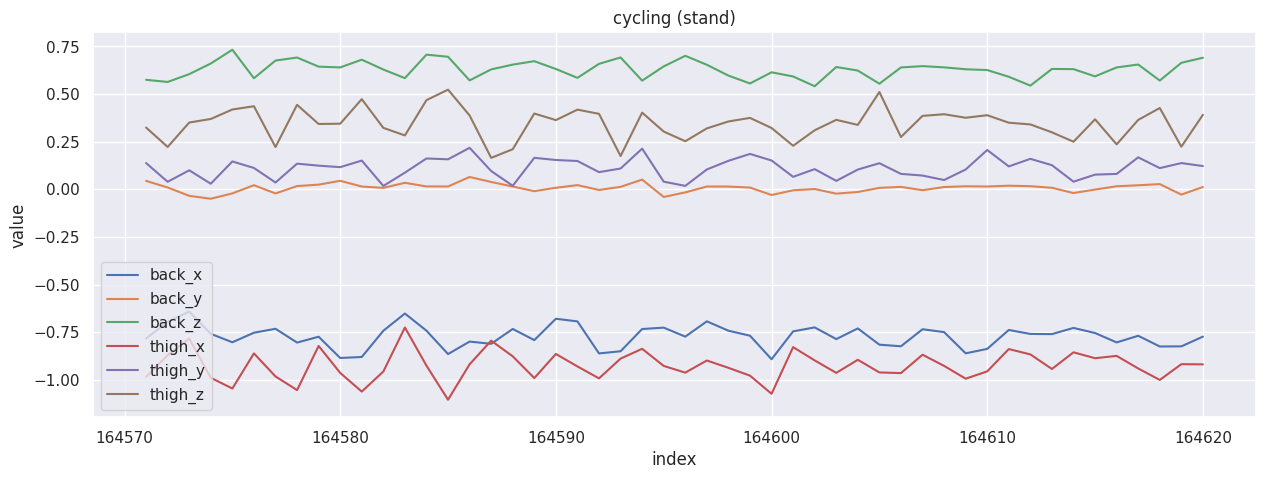

In [ ]:
plotInertialWindow(starting_index=164571, window_len=50, df_columns=["back_x", "back_y", "back_z", "thigh_x", "thigh_y", "thigh_z"])

When plotting different windows, it's possible to see how the signals seem to be quite "smooth" and don't have strange behaviors.

In the paper describing the dataset, the application of a low pass filter at 20Hz is advised: this is due to the fact that human body movements are below this frequency.

Let's now visualize the effect of applying a 20Hz low pass Butterworth filter of order 4 to the signals. Here I'm plotting the effect on the x-axis accelerometer placed on the back of the subject but a similar behavior can be seen on the other components of the signal.

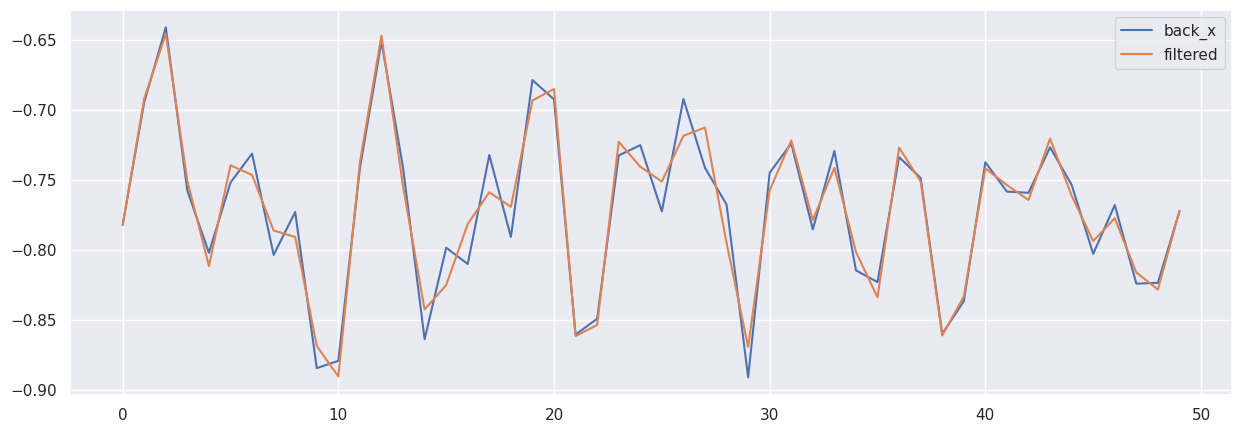

In [ ]:
from scipy import signal

#let's select a portion of the signal
arbitrary_index = 164571

tmp_df = df.iloc[arbitrary_index:arbitrary_index+50]  # get a window of 50 rows/measurements of the dataframe i.e. 1 seconds window
tmp_df = tmp_df.reset_index()

#plot signal before processing
tmp_df["back_x"].plot()

fs=50 #sampling frequency
fc=20 #cut-off frequency
wn= fc/(fs/2) #normalized cut off frequency

b,a=signal.butter(4, wn, 'low')
filtered = signal.filtfilt(b,a, tmp_df["back_x"])
plt.plot(filtered, label='filtered')
plt.legend()

Filtering doesn't seem to have an huge effect on the signal, but I have tried to run a simple classification model on both filtered and unfiltered data and I have noticed an increase in classification accuracy, so I have decided to apply this filter.

Data also needs to be standardized: in this way the distribution of values is rescaled so that the observed values have a null mean and an unitary standard deviation. The following code blocks allow to visualize the effect of standardization over a given window of measuraments.


Text(0.5, 1.0, 'cycling (stand)')

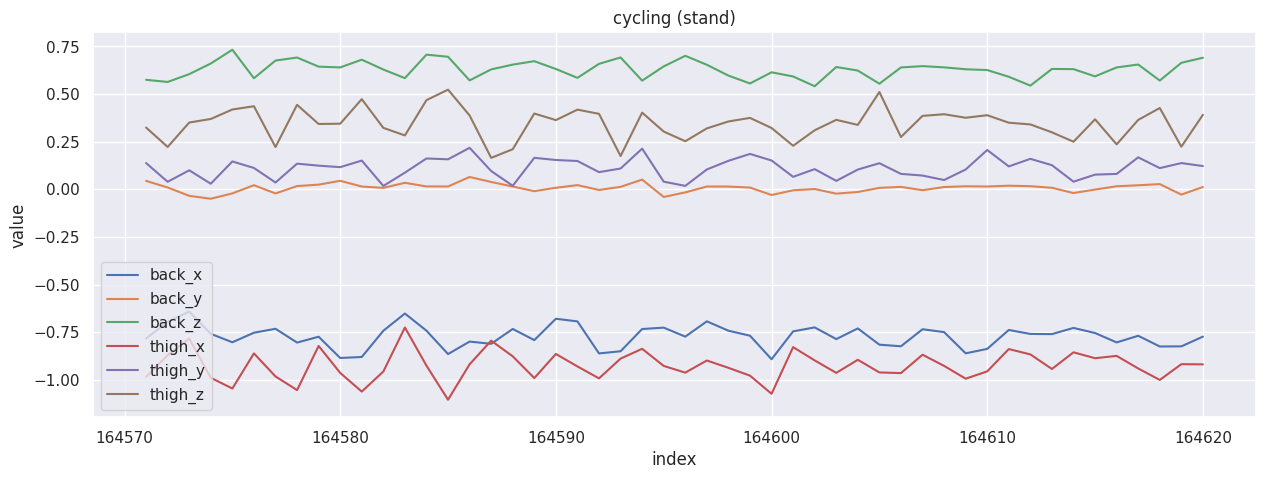

In [ ]:
from statistics import mode
arbitrary_index = 164571

tmp_df = df.iloc[arbitrary_index:arbitrary_index+50]
tmp_df = tmp_df.reset_index()

labels_list = list(tmp_df["label"])
label = mode(labels_list)
label = str(label)

sns.lineplot(data=tmp_df, x='index', y='back_x', label="back_x")
sns.lineplot(data=tmp_df, x='index', y='back_y', label="back_y")
sns.lineplot(data=tmp_df, x='index', y='back_z', label="back_z")
sns.lineplot(data=tmp_df, x='index', y='thigh_x', label="thigh_x")
sns.lineplot(data=tmp_df, x='index', y='thigh_y', label="thigh_y")
sns.lineplot(data=tmp_df, x='index', y='thigh_z', label="thigh_z")

plt.ylabel("value")
plt.title(activities_map[label])

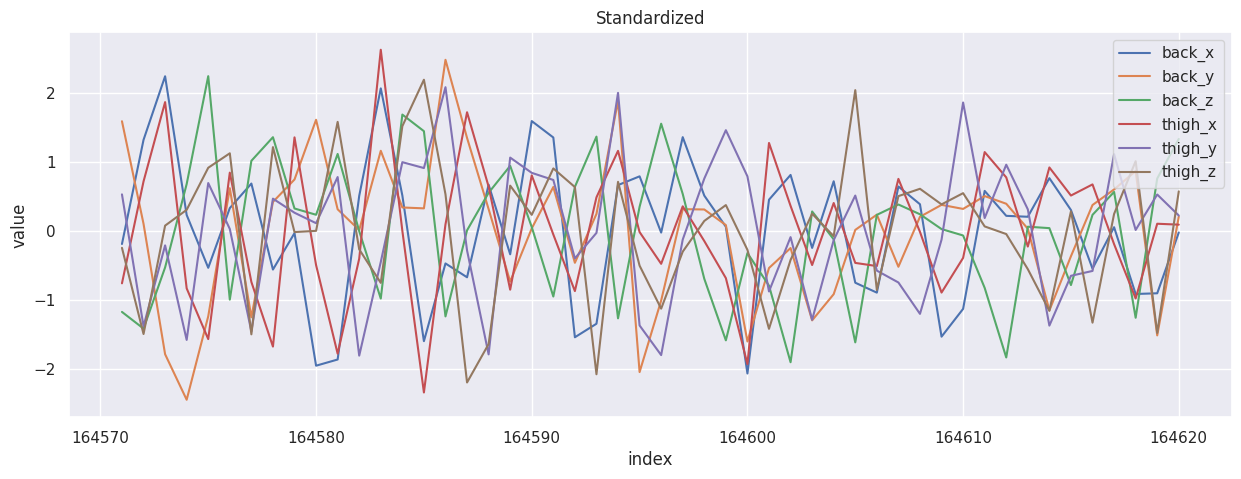

In [ ]:
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()
tmp_df[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']] = standardScaler.fit_transform(tmp_df[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']])

sns.lineplot(data=tmp_df, x='index', y='back_x', label="back_x")
sns.lineplot(data=tmp_df, x='index', y='back_y', label="back_y")
sns.lineplot(data=tmp_df, x='index', y='back_z', label="back_z")
sns.lineplot(data=tmp_df, x='index', y='thigh_x', label="thigh_x")
sns.lineplot(data=tmp_df, x='index', y='thigh_y', label="thigh_y")
sns.lineplot(data=tmp_df, x='index', y='thigh_z', label="thigh_z")

plt.ylabel("value")
plt.title('Standardized')

plt.show()

### Data segmentation


Note that not all subject files are organized in the same way. Most of them have the following structure, with columns:
* 0: timestamp
* 1-3: intertial measuraments from Accelerometer on the back
* 4-6: intertial measuraments from Accelerometer on the thigh
* 7: label i.e. activity class ID

The exceptions are subjects 15, 21 and 23 for which an extra column is present, so the file is divided in this way:
* 0: timestamp
* 1: index
* 2-4: intertial measuraments from Accelerometer on the back
* 5-7: intertial measuraments from Accelerometer on the thigh
* 8: label i.e. activity class ID

Here I inspect the three subjects for which the collected data has a different structure respect to the rest: we already saw these cases as exceptions in the previous sections.

The goal here is to undestand which columns of the dataframes I need to consider: soon I will create a single dataframe with data from all 22 subjects and it should have an homogeneous structure.

In [ ]:
# most subjects' dataframes have the following structure
df = pd.read_csv(f"harth/S006.csv", sep=',', header=0, engine='python')
df.head()
# here no need of selecting columns

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6
1,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6
2,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6
3,2019-01-12 00:00:00.060,-1.187088,-0.005508,0.056683,-0.520771,0.154755,-0.232140,6
4,2019-01-12 00:00:00.080,-0.841369,0.129879,0.122489,-0.954652,-0.293586,-0.184660,6


In [ ]:
# inspection of "special" subjects

df = pd.read_csv(f"harth/S015.csv", sep=',', header=0, engine='python')
df.head()
#here I want to keep columns 0,2,3...8

,timestamp,index,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,0,-0.999492,0.023192,0.025461,-0.935965,0.023979,-0.355521,6
1,2019-01-12 00:00:00.020,1,-0.995551,0.021414,0.042297,-0.928875,0.029540,-0.371151,6
2,2019-01-12 00:00:00.040,2,-0.989507,0.012187,0.038830,-0.942907,0.019677,-0.359649,6
3,2019-01-12 00:00:00.060,3,-0.991327,0.015926,0.056181,-0.942363,0.009682,-0.348916,6
4,2019-01-12 00:00:00.080,4,-0.997368,0.014239,0.035168,-0.930852,0.012002,-0.357421,6


In [ ]:
df = pd.read_csv(f"harth/S021.csv", sep=',', header=0, engine='python')
df.head()
#here I want to keep columns 0,2,3...8

,timestamp,index,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,18655.0,-0.890627,-0.046514,0.155150,-2.487524,0.819993,0.398369,6
1,2019-01-12 00:00:00.020,18656.0,-0.766607,0.007558,0.278709,0.336440,-0.003382,-1.068319,6
2,2019-01-12 00:00:00.040,18657.0,-0.606894,-0.020571,-0.079821,0.593737,-1.517406,-1.337046,6
3,2019-01-12 00:00:00.060,18658.0,-0.590938,0.045517,0.101753,0.188680,-2.725969,-1.339347,6
4,2019-01-12 00:00:00.080,18659.0,-0.444522,0.026991,-0.304779,-1.384996,-1.336540,0.373945,6


In [ ]:
df = pd.read_csv(f"harth/S023.csv", sep=',', header=0, engine='python')
df.head()
#here we want to keep columns 1,2,3...8

,Unnamed: 0,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,0,2019-01-12 00:00:00.000,-1.108887,0.057861,-0.076904,-1.396973,-0.327148,-0.141846,6
1,1,2019-01-12 00:00:00.020,-1.054932,0.073486,-0.113770,-1.363281,-0.386475,-0.321533,6
2,2,2019-01-12 00:00:00.040,-0.911377,-0.007568,-0.160156,-1.080078,-0.096680,-0.354492,6
3,3,2019-01-12 00:00:00.060,-0.865234,-0.062500,-0.176025,-1.012939,0.163574,-0.229736,6
4,4,2019-01-12 00:00:00.080,-0.992920,-0.026123,-0.178467,-0.989014,0.199951,-0.088379,6


Now let's create a single dataframe containg all data from all subjects: it will have the same structure of the majority of single subject dataframes plus an extra column for storing the subject identification number.

Before being added to the dataframe, data is filtered and standardized as shown in the previous section.



In [ ]:
df = pd.DataFrame()

acts_dict = {str(i):0 for i in [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 130, 140]}
subjects_dict = {i:dict(acts_dict) for i in range(6, 30) if i not in [7, 11]}

#paramteres for the later applied butterworth low pass filter + standardization
fs=50 #sampling frequency
fc=20 #cut-off frequency
wn= fc/(fs/2) #normalized cut off frequency
b,a=signal.butter(4, wn, 'low')
standardScaler = StandardScaler()

for subject in subjects_dict.keys():
  print(f"Subject {subject}")
  print("\tCreating the dataframe...")
  if subject < 10:
    single_df = pd.read_csv(f"harth/S00{subject}.csv", sep=',', header=0, engine='python')
  else:
    single_df = pd.read_csv(f"harth/S0{subject}.csv", sep=',', header=0, engine='python')
    if subject in [15, 21]:
      single_df = single_df.iloc[:,[0,2,3,4,5,6,7,8]] # select columns as seen before
    elif subject == 23:
      single_df = single_df.iloc[:,[1,2,3,4,5,6,7,8]] # select columns as seen before

  single_df['subject_id'] = subject

  print("\tFiltering data...\n") # apply the low pass Butterworth filter introduced before:
  single_df['back_x']  = signal.filtfilt(b,a, single_df['back_x'])
  single_df['back_y']  = signal.filtfilt(b,a, single_df['back_y'])
  single_df['back_z']  = signal.filtfilt(b,a, single_df['back_z'])
  single_df['thigh_x']  = signal.filtfilt(b,a, single_df['thigh_x'])
  single_df['thigh_y']  = signal.filtfilt(b,a, single_df['thigh_y'])
  single_df['thigh_z']  = signal.filtfilt(b,a, single_df['thigh_z'])

  df = pd.concat([df, single_df], ignore_index=True)

print("Standardizing everything...")
df[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']] = standardScaler.fit_transform(df[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']])
df.head()

Subject 6
	Creating the dataframe...
	Filtering data...

Subject 8
	Creating the dataframe...
	Filtering data...

Subject 9
	Creating the dataframe...
	Filtering data...

Subject 10
	Creating the dataframe...
	Filtering data...

Subject 12
	Creating the dataframe...
	Filtering data...

Subject 13
	Creating the dataframe...
	Filtering data...

Subject 14
	Creating the dataframe...
	Filtering data...

Subject 15
	Creating the dataframe...
	Filtering data...

Subject 16
	Creating the dataframe...
	Filtering data...

Subject 17
	Creating the dataframe...
	Filtering data...

Subject 18
	Creating the dataframe...
	Filtering data...

Subject 19
	Creating the dataframe...
	Filtering data...

Subject 20
	Creating the dataframe...
	Filtering data...

Subject 21
	Creating the dataframe...
	Filtering data...

Subject 22
	Creating the dataframe...
	Filtering data...

Subject 23
	Creating the dataframe...
	Filtering data...

Subject 24
	Creating the dataframe...
	Filtering data...

Subject 25
	Creat

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,subject_id
0,2019-01-12 00:00:00.000,0.336000,1.355591,1.762716,-7.211229,-0.816987,0.470703,6,6
1,2019-01-12 00:00:00.020,-0.488499,0.830576,0.001673,0.689622,-0.376791,-1.202597,6,6
2,2019-01-12 00:00:00.040,0.962052,-0.099865,0.140211,0.470012,0.564347,-1.416493,6,6
3,2019-01-12 00:00:00.060,-0.285173,-0.051994,0.617123,-0.317845,0.032138,-0.803649,6,6
4,2019-01-12 00:00:00.080,-0.324608,0.720207,0.812434,-0.146119,-0.444462,-0.775806,6,6


In [ ]:
df.tail()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,subject_id
6265675,2019-01-12 00:59:56.940,-0.338161,-0.407353,-0.164053,-0.589277,-0.863821,-0.334476,3,29
6265676,2019-01-12 00:59:56.960,-0.237286,-0.341979,-0.122764,-0.588012,-0.641874,-0.346844,3,29
6265677,2019-01-12 00:59:56.980,-0.222270,-0.179399,-0.123826,-0.631880,-0.304781,-0.413065,3,29
6265678,2019-01-12 00:59:57.000,-0.300324,-0.076576,-0.182462,-0.641080,-0.418741,-0.420931,3,29
6265679,2019-01-12 00:59:57.020,-0.337730,-0.074264,-0.146348,-0.638375,-0.831896,-0.395044,3,29


As mentioned in the exploratory data analysis, to mitigate class imbalance it's possible to group together some activities. Here I performed this step.

In [ ]:
df['label'].unique() # labels present in the dataframe

array([  6,   1,   3,   7,   4,   5,   8, 130,  13,  14, 140,   2])

In [ ]:
# this will be the new activities map
activities_map = {
    "1": "walking",
    "2": "running",
    "4": "stairs (ascending)",
    "5": "stairs (descending)",
    "6": "standing", #this now will also contain data which was labeled as 3 (shuffling)
    "7": "sitting",
    "8": "lying",
    "13": "cycling (sit)", #this now will also contain data which was labeled as 130 (cycling, sit, inactive)
    "14": "cycling (stand)"  #this now will also contain data which was labeled as 140 (cycling, stand, inactive)
}

In [ ]:
df['label'] = df['label'].replace(3,6)
df['label'] = df['label'].replace(130,13)
df['label'] = df['label'].replace(140,14)

In [ ]:
df['label'].unique() # labels now present in the dataframe

array([ 6,  1,  7,  4,  5,  8, 13, 14,  2])

Now that all data from all subjects is part of a single dataframe, it's time to perform segmentation.

Following what suggested in the paper describing the dataset HARTH, the time series will be segmented into non-overlapping one-second
windows (50 samples at 50 Hz). Majority of annotated labels in a single window is used as the corresponding ground truth.

In [ ]:
sampling_rate = 50     # 50 Hz
window_len = 1*sampling_rate       # windows of 1 second
back_samples, thigh_samples, labels, subjects, tss = [], [], [], [], []

for subject in subjects_dict.keys():
  print(f"Subject {subject}...")

  # get the sub-dataframe that contains only the data samples of the considered subject
  subject_df = df.loc[df['subject_id'] == subject]

  # first index of the sub-dataframe
  start = 0
  # last index of the sub-dataframe
  last = subject_df.shape[0]
  while start < last:     # loop until you have scanned all the subject's data samples
    end = start + window_len #last index of current window

    # get the portion of dataframe included between the start and the end timestamps
    tmp_df = subject_df.iloc[start:end]

    # create windows of back and thigh accelerometer data
    back_win = tmp_df[["back_x", "back_y", "back_z"]].to_numpy()
    thigh_win = tmp_df[["thigh_x", "thigh_y", "thigh_z"]].to_numpy()

    # go on only if the windows include 50 measurements
    if (len(back_win) == window_len) and (len(thigh_win) == window_len):
      # get the most frequent label in tmp_df
      lab = tmp_df['label'].mode()[0]

      # store everything in the main data structures
      back_samples.append(back_win)
      thigh_samples.append(thigh_win)
      labels.append(lab)
      subjects.append(subject)
      tss.append(start)

    # update the start index
    start = end

back_samples = np.asarray(back_samples)
thigh_samples = np.asarray(thigh_samples)
labels = np.asarray(labels)
subjects = np.asarray(subjects)
tss = np.asarray(tss)

print()
print(f"Back data: {back_samples.shape}")
print(f"Thigh data: {thigh_samples.shape}")
print(f"Labels data: {labels.shape}")
print(f"Subjects data: {subjects.shape}")

Subject 6...
Subject 8...
Subject 9...
Subject 10...
Subject 12...
Subject 13...
Subject 14...
Subject 15...
Subject 16...
Subject 17...
Subject 18...
Subject 19...
Subject 20...
Subject 21...
Subject 22...
Subject 23...
Subject 24...
Subject 25...
Subject 26...
Subject 27...
Subject 28...
Subject 29...

Back data: (125301, 50, 3)
Thigh data: (125301, 50, 3)
Labels data: (125301,)
Subjects data: (125301,)


Now let's look again at the data distribution: in the previous section some activities have been grouped together so distribution will be indeed different with respect to what has been shown in the first section.

In [ ]:
labels_count = {activities_map[str(lab)]:list(labels).count(lab) for lab in list(set(labels))}
labels_count = pd.DataFrame(labels_count.items(), columns=["activity", "support"])
labels_count

,activity,support
0,walking,23709
1,running,5828
2,stairs (ascending),1521
3,stairs (descending),1333
4,standing,19282
5,sitting,55544
6,lying,8489
7,cycling (sit),8350
8,cycling (stand),1245


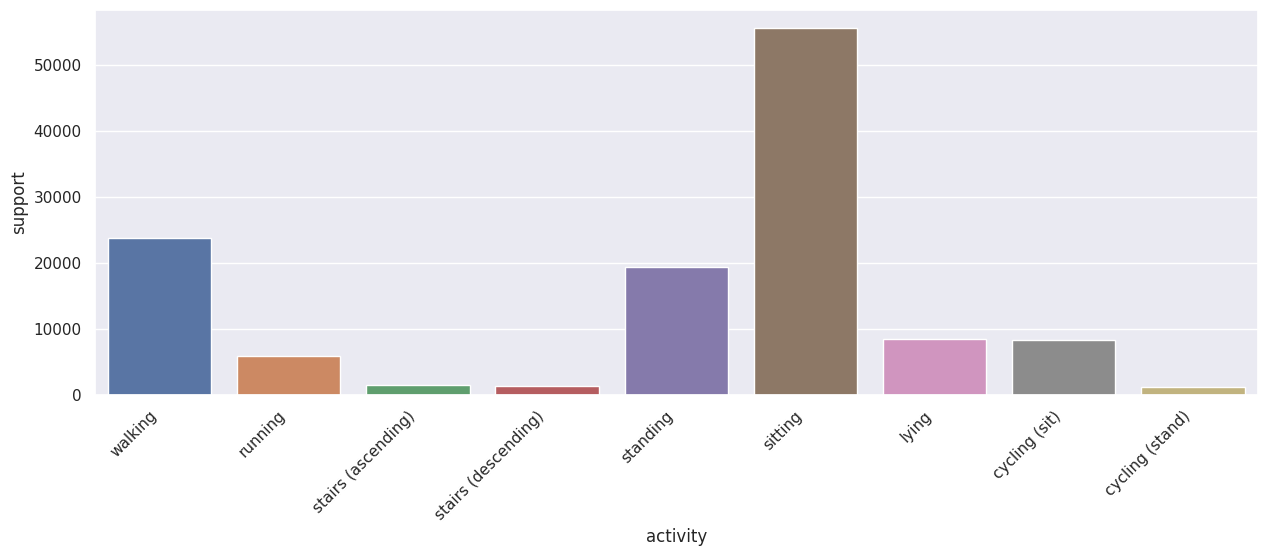

In [ ]:
sns.barplot(data=labels_count, x="activity", y="support")
plt.xticks(rotation=45, ha="right")
plt.show()

Even after grouping together some activities, the data distribution is far from uniform; it's now time to select a  portion of sitting data, as mentioned in the first section. This will make the dataset much more balanced.

In [ ]:
# sitting -> label 7 -> pick 43 % of data to have a similar number of samples as in "walking"
tmp = np.where(labels == 7)[0]
random_sample = np.random.choice(tmp, int(tmp.shape[0] * 0.43), replace=False)
new_idx = np.where(labels != 7)[0]
new_idx = np.concatenate((new_idx, random_sample))


Let's save this final version of the segmented and processed dataset, in order to avoid repeating this work everytime.

In [ ]:
filename = f"{project_path}/HARTH_1sec_df_reduced.txt"

harth_red = {
    "back_samples" : back_samples[new_idx],
    "thigh_samples" : thigh_samples[new_idx],
    "labels" : labels[new_idx],
    "subjects" : subjects[new_idx]
}

with open(filename, "wb") as f:
  pickle.dump(harth_red, f)

del harth_red

In [ ]:
with open(f"{project_path}/HARTH_1sec_df_reduced.txt", "rb") as f: #load the preprocessed&segmented data
  harth_red = pickle.load(f)

back_samples = harth_red['back_samples']
thigh_samples = harth_red['thigh_samples']
labels = harth_red['labels']
subjects = harth_red['subjects']

del harth_red

print(f"Back accelerometer data: {back_samples.shape}")
print(f"Thigh accelerometer data: {thigh_samples.shape}")
print(f"Subject data: {subjects.shape}")
print(f"Labels: {labels.shape}")

Back accelerometer data: (93640, 50, 3)
Thigh accelerometer data: (93640, 50, 3)
Subject data: (93640,)
Labels: (93640,)


Finally, visualize the new and final data distribution.

In [ ]:
labs_count = {activities_map[str(lab)]:list(labels).count(lab) for lab in list(set(labels))}
labs_count = pd.DataFrame(labs_count.items(), columns=["activity", "support"])
labs_count

,activity,support
0,walking,23709
1,running,5828
2,stairs (ascending),1521
3,stairs (descending),1333
4,standing,19282
5,sitting,23883
6,lying,8489
7,cycling (sit),8350
8,cycling (stand),1245


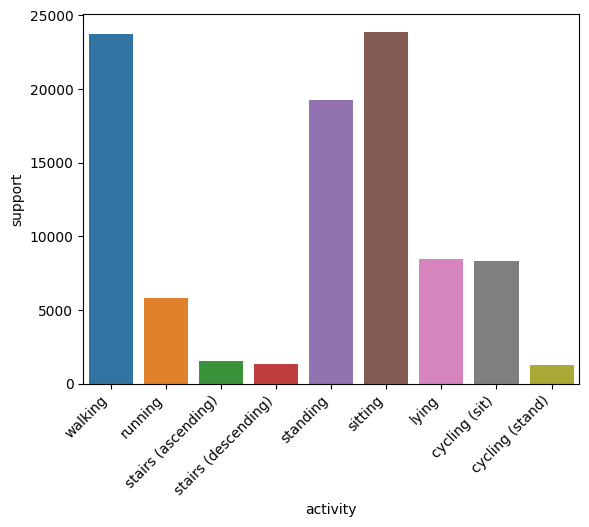

In [ ]:
sns.barplot(data=labs_count, x="activity", y="support")
plt.xticks(rotation=45, ha="right")
plt.show()

# Building the models

In this section I will create a different classifiers for the data processed above.

#### Useful
Import all useful libraries, set the seeds to allow reproducibility of results, set the GPU and slit data in "old" and "new".

In [ ]:
import os
import torch
from sklearn.preprocessing import OneHotEncoder
import pickle, numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from numpy.random import seed

seed(3)
tf.keras.utils.set_random_seed(3)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
project_path =  "/content/drive/MyDrive/ColabData/AmID/replay"

Mounted at /content/drive


In [ ]:
with open(f"{project_path}/HARTH_1sec_df_reduced.txt", "rb") as f: #load the preprocessed&segmented data
  harth = pickle.load(f)

back_samples = harth['back_samples']
thigh_samples = harth['thigh_samples']
labels = harth['labels']
subjects = harth['subjects']

del harth

print(f"Back accelerometer data: {back_samples.shape}")
print(f"Thigh accelerometer data: {thigh_samples.shape}")
print(f"Subject data: {subjects.shape}")
print(f"Labels: {labels.shape}")

Back accelerometer data: (93640, 50, 3)
Thigh accelerometer data: (93640, 50, 3)
Subject data: (93640,)
Labels: (93640,)


As I'm exploring the case of class-incremental learning, I have to simulate the arrival of one (or more) class at a different time.

Let's suppose that at the beginning data from all classes but "lying" are available, and such data becomes available in a second moment. Here I am preparing this setting by defiying two activities maps and by splitting data in old and new.

In [ ]:
activities_map_old = {
    1: "walking",
    2: "running",
    4: "stairs (ascending)",
    5: "stairs (descending)",
    6: "standing",
    7: "sitting",
    13: "cycling (sit)",
    14: "cycling (stand)"
}

classes_names_old = list(activities_map_old.values())

In [ ]:
activities_map = {
    1: "walking",
    2: "running",
    4: "stairs (ascending)",
    5: "stairs (descending)",
    6: "standing",
    7: "sitting",
    13: "cycling (sit)",
    14: "cycling (stand)",
    8: "lying" # this at the end because is the activity which will be added
}

classes_names = list(activities_map.values())

In [ ]:
#indices of old + new data, coming later in time,  8 = 'lying'
old_data = np.where((labels != 8))[0]
new_data = np.where((labels == 8))[0]

# split train & test of old data + labels
old_train, old_test, lab_old_train, lab_old_test = train_test_split(old_data, labels[old_data], test_size=0.20, random_state=0)
# split in train & test new data + labels
new_train, new_test, lab_new_train, lab_new_test= train_test_split(new_data, labels[new_data], test_size=0.20, random_state=0)

In the last block I have performed an hold-out train test split so that I have data ready for training and testing of NN models.

Let's save such split so that it will be used in all the following sections, avoing test and train data to be mixed.

In [ ]:
filename = f'/content/drive/MyDrive/ColabData/AmID/replay/red_train_test_split.txt'

data = {
    "old_train" : old_train,
    "old_test" : old_test,
    "lab_old_train" : lab_old_train,
    "lab_old_test" : lab_old_test,
    "new_train" : new_train,
    "new_test" : new_test,
    "lab_new_train" : lab_new_train,
    "lab_new_test" : lab_new_test,
}

with open(filename, "wb") as f:
  pickle.dump(data, f)

del data

In [ ]:
# re-load test train split for both old & new data

with open(f"/content/drive/MyDrive/ColabData/AmID/replay/red_train_test_split.txt", "rb") as f:
  data = pickle.load(f)

old_train = data['old_train']
old_test = data['old_test']
lab_old_train = data['lab_old_train']
lab_old_test = data['lab_old_test']
new_train = data['new_train']
new_test = data['new_test']
lab_new_train = data['lab_new_train']
lab_new_test = data['lab_new_test']

del data

### Base model

This model classifies the given input in one of 8 classes, each representing one of the activities in "activities_map_old" i.e. all considered activities other than lying.

I have decided to process "in parallel" the back accelerometer and the thigh accelerometer data. Each triplet of data (one for every spatial axis) is fed through a 1D convolutional network which has 3 convolutional layers alternated with max pooling layers. The outputs of the two global max pooling layers are then concatenated and processed through a dense layer for classification.

I have tested different hyperparameters and the ones seen below yielded the best results, I have also followed some of the suggestions present in the HARTH dataset paper, in which advices on hyperparameters values were given.

In [ ]:
def base_model(num_classes=8, print_summary=False):
  back_input = tf.keras.layers.Input((50, 3), name="back_input")
  thigh_input = tf.keras.layers.Input((50, 3), name="thigh_input")

  x = tf.keras.layers.Conv1D(filters=128, kernel_size=6, strides=1, activation='relu', name="conv_1b")(back_input)
  x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, name="max_pool_1b")(x)
  x = tf.keras.layers.Conv1D(filters=128, kernel_size=12, strides=1, activation='relu', name="conv_2b")(x)
  x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, name="max_pool_2b")(x)
  x = tf.keras.layers.Conv1D(filters=128, kernel_size=12, strides=1, activation='relu', name="conv_3b")(x)
  x = tf.keras.layers.GlobalMaxPool1D(name='global_max_poolingb')(x)

  y = tf.keras.layers.Conv1D(filters=128, kernel_size=6, strides=1, activation='relu', name="conv_1t")(thigh_input)
  y = tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, name="max_pool_1t")(y)
  y = tf.keras.layers.Conv1D(filters=128, kernel_size=12, strides=1, activation='relu', name="conv_2t")(y)
  y = tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, name="max_pool_2t")(y)
  y = tf.keras.layers.Conv1D(filters=128, kernel_size=12, strides=1, activation='relu', name="conv_3t")(y)
  y = tf.keras.layers.GlobalMaxPool1D(name='global_max_poolingt')(y)

  #x = tf.keras.layers.Flatten()(x)
  concat = tf.keras.layers.Concatenate(name="concatenate")([x, y])

  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(concat)

  model = tf.keras.models.Model(inputs=[back_input, thigh_input], outputs=classification_out, name='base_model')

  if print_summary:
    print(model.summary())

  return model

model = base_model(print_summary=True)

Model: "base_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 back_input (InputLayer)     [(None, 50, 3)]              0         []                            
                                                                                                  
 thigh_input (InputLayer)    [(None, 50, 3)]              0         []                            
                                                                                                  
 conv_1b (Conv1D)            (None, 45, 128)              2432      ['back_input[0][0]']          
                                                                                                  
 conv_1t (Conv1D)            (None, 45, 128)              2432      ['thigh_input[0][0]']         
                                                                                         

In [ ]:
# early stopping: if for 5 consecutive epochs the loss on the validation set does not improve, we stop the training process and restore the weights of the best model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

n_epochs = 80
batch_size = 128

#let's get the one hot encodings
enc = OneHotEncoder()
ohe_labels_old_train = enc.fit_transform(labels[old_train].reshape(-1,1)).toarray()
ohe_labels_old_test = enc.fit_transform(labels[old_test].reshape(-1,1)).toarray()


# get validation data
old_train, old_val, ohe_labels_old_train, ohe_labels_old_val = train_test_split(old_train, ohe_labels_old_train, test_size=0.2)


print("\nCreating the model...")
model = base_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


print("\nTraining...")

history = model.fit(x=[back_samples[old_train], thigh_samples[old_train]],
                  y=ohe_labels_old_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = ([back_samples[old_val], thigh_samples[old_val]], ohe_labels_old_val),
                  callbacks=[early_stopping])


print("\nSaving model...")
model.save(f"{project_path}/old_model_r")


Creating the model...

Training...
Epoch 1/80
426/426 [==============================] - 17s 12ms/step - loss: 0.3181 - accuracy: 0.9022 - val_loss: 0.2550 - val_accuracy: 0.9182
Epoch 2/80
426/426 [==============================] - 4s 10ms/step - loss: 0.2127 - accuracy: 0.9323 - val_loss: 0.2067 - val_accuracy: 0.9336
Epoch 3/80
426/426 [==============================] - 5s 12ms/step - loss: 0.1911 - accuracy: 0.9383 - val_loss: 0.2094 - val_accuracy: 0.9327
Epoch 4/80
426/426 [==============================] - 5s 11ms/step - loss: 0.1806 - accuracy: 0.9403 - val_loss: 0.2095 - val_accuracy: 0.9318
Epoch 5/80
426/426 [==============================] - 4s 10ms/step - loss: 0.1699 - accuracy: 0.9437 - val_loss: 0.1948 - val_accuracy: 0.9373
Epoch 6/80
426/426 [==============================] - 5s 12ms/step - loss: 0.1617 - accuracy: 0.9469 - val_loss: 0.1974 - val_accuracy: 0.9386
Epoch 7/80
426/426 [==============================] - 5s 11ms/step - loss: 0.1537 - accuracy: 0.9490 - va

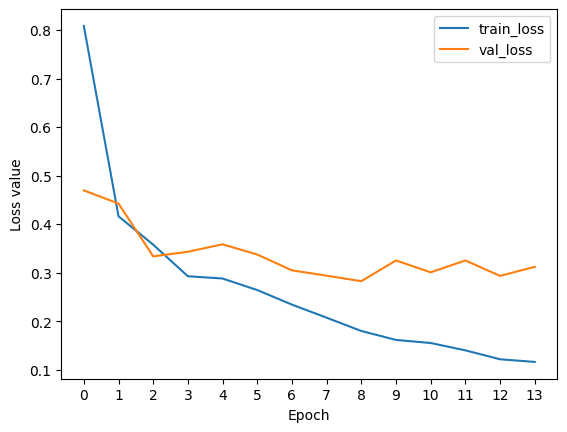

In [ ]:
epoch_axis_values = list(range(len(history.history["loss"])))

plt.plot(epoch_axis_values, history.history["loss"], label="train_loss")
plt.plot(epoch_axis_values, history.history["val_loss"], label="val_loss")
plt.xticks(epoch_axis_values)
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.legend()
plt.show()

Here the plot of training loss vs validation loss shows how the model slightly overfits, but it seems to be a good model.

Let's see the prediction performance.

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, cmap=plt.cm.Blues, figsize=(22,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=+++90, fontsize=11)
    plt.yticks(tick_marks, classes, fontsize=11)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black"
               )

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.tick_params(axis="both", which="both", bottom=False, left=False)
    plt.grid(False)
    plt.box(False) #remove box
    return plt


Predicting...
533/533 [==============================] - 2s 4ms/step

Classification Report:
                     precision    recall  f1-score   support

            walking     0.9412    0.8842    0.9118      4691
            running     0.9884    0.9715    0.9799      1227
 stairs (ascending)     0.7782    0.7782    0.7782       284
stairs (descending)     0.8397    0.7866    0.8122       253
           standing     0.8795    0.9427    0.9100      3873
            sitting     0.9921    0.9975    0.9948      4766
      cycling (sit)     0.9619    0.9766    0.9692      1707
    cycling (stand)     0.8733    0.8391    0.8559       230

           accuracy                         0.9409     17031
          macro avg     0.9068    0.8970    0.9015     17031
       weighted avg     0.9418    0.9409    0.9408     17031


Confusion Matrix:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

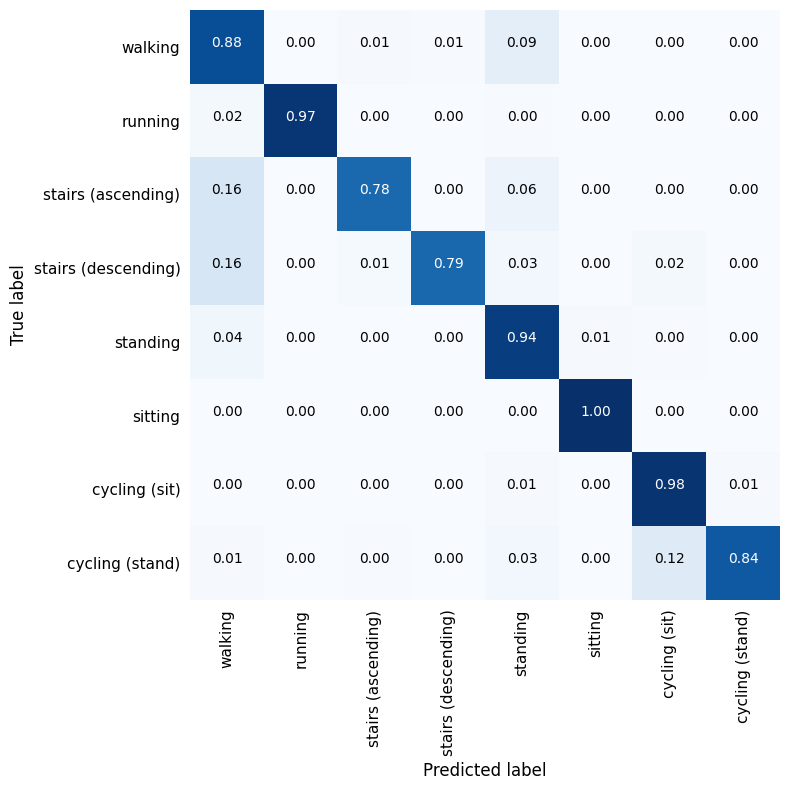

In [ ]:
model = tf.keras.models.load_model(f"{project_path}/old_model_r")

print("\nPredicting...")
y_preds = model.predict([back_samples[old_test], thigh_samples[old_test]])

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_labels_old_test, axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names_old, labels=np.array([i for i in range(len(classes_names_old))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names_old[el])
for el in y_targets: s_targets.append(classes_names_old[el])

cm = [np.zeros([len(classes_names_old)]) for _ in range(len(classes_names_old))]
cm += confusion_matrix(s_targets, s_preds, labels=classes_names_old)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names_old)



Here are some examples of other tested hyperparameters and the associated results, I have decided to summarize them here to not make this section too long.

* Different number of convolutional filters e.g. increasing number 32-64-128

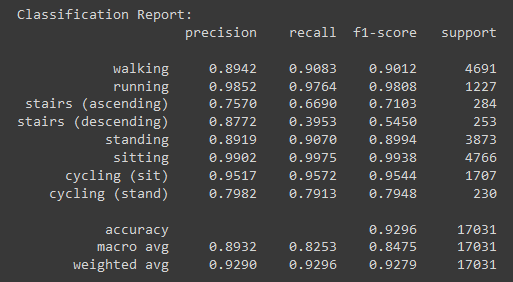

* Same model as "base_model" but without layers conv_2b, max_pool_2b, conv_2t max_pool_2t

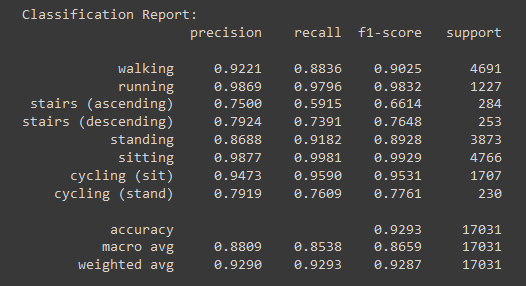


* Concatenation of back and thigh samples at the beginning, then similar structure as one side of "base_model"

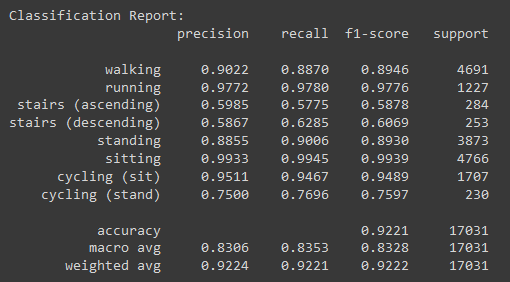

* Same model as "base_model" but with increased batch size (384)

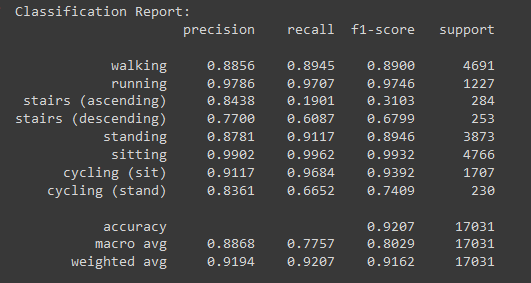

* Same model al base_model but trained with SGD instead of adam

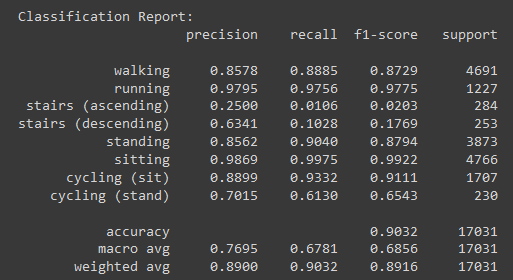


### Baseline

Model used to classify both new and old data, trained without any CL technique.

The idea behind the baseline is the following: the old model can be seen as a feature extractor + an 8 class classifier, now that the number of classes changes the feature extractor can be kept but the classifier has to be changed. Other than the structure of the feature extractor, it's possible to freeze its weights (or part of them).

I defined the new classifier in a flexible way so that it is possible to freeze the weights of the desidered number of layers.

In [ ]:
def new_classifier(base_model, n_freeze = 14, num_classes=9):
  # n_freeze is an integer even number ranging from 0 to 14
  # pick it even to freeze layers in a symmetrical way x thigh & back samples!
  # n_freeze =  0 -> completely trainable model
  # n_freeze = 14 -> all layers frozen other than the last two (concatenation & classification) DEFAULT OPT.

  feature_extractor_b = base_model.get_layer("conv_3b").output #related to back acc
  feature_extractor_t = base_model.get_layer("conv_3t").output #related to thigh acc

  b = tf.keras.layers.GlobalMaxPool1D(name='global_max_pooling_b')(feature_extractor_b)
  t = tf.keras.layers.GlobalMaxPool1D(name='global_max_pooling_t')(feature_extractor_t)
  conc = tf.keras.layers.Concatenate(name="concatenated")([b, t])

  classification_out = tf.keras.layers.Dense(9, activation='softmax', name="classification_out")(conc)

  model = tf.keras.Model(inputs= base_model.input, outputs=classification_out, name="new_classifier")

  if n_freeze > 0 :
    for layer in model.layers[0: n_freeze] : layer.trainable = False

  for layer in model.layers[n_freeze:-2]: layer.trainable = True

  return model

In [ ]:
old_model = tf.keras.models.load_model(f"{project_path}/old_model_r")

model = new_classifier(old_model, n_freeze = 6)
print(model.summary())

print("\nTrainable layers:")
for layer in model.layers:
  print(layer.name, layer.trainable)

Model: "new_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 back_input (InputLayer)     [(None, 50, 3)]              0         []                            
                                                                                                  
 thigh_input (InputLayer)    [(None, 50, 3)]              0         []                            
                                                                                                  
 conv_1b (Conv1D)            (None, 45, 128)              2432      ['back_input[0][0]']          
                                                                                                  
 conv_1t (Conv1D)            (None, 45, 128)              2432      ['thigh_input[0][0]']         
                                                                                     

Here I am loading the pre-trained old model (base model) and then training three new classifiers: one with all frozen layer, one with the first portion of the layers frozen and lastly a completly trainable one.

The training data is data from the new class (lying), and the testing data contains both old testing data (from the first 8 classes) and new data (from class lying).


In [ ]:
# the following is used in all models, let's define it only once
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
n_epochs = 80
batch_size = 128

enc = OneHotEncoder()
ohe_labels_old_train = enc.fit_transform(labels[old_train].reshape(-1,1)).toarray()
ohe_labels_old_test = enc.fit_transform(labels[old_test].reshape(-1,1)).toarray()

enc = OneHotEncoder(categories=[range(len(classes_names))], sparse=False)
ohe_labels_new_train = enc.fit_transform(labels[new_train].reshape(-1,1))
ohe_labels_new_test = enc.fit_transform(labels[new_test].reshape(-1,1))

# get validation data
new_train, new_val, ohe_labels_new_train, ohe_labels_new_val = train_test_split(new_train, ohe_labels_new_train, test_size=0.1)

print("Loading the pre-trained model...")
old_model = tf.keras.models.load_model(f"{project_path}/old_model_r")

Loading the pre-trained model...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Creating the new classifier...

Training on new data...
Epoch 1/80
43/43 [==============================] - 2s 25ms/step - loss: 2.0504 - accuracy: 0.5363 - val_loss: 0.1145 - val_accuracy: 0.9967
Epoch 2/80
43/43 [==============================] - 0s 6ms/step - loss: 0.0453 - accuracy: 0.9998 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 3/80
43/43 [==============================] - 0s 6ms/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 4/80
43/43 [==============================] - 0s 6ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 5/80
43/43 [==============================] - 0s 5ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 6/80
43/43 [==============================] - 0s 6ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 7/80
43/43 [==============================] - 0s 5ms/step - loss: 0.0041 - accuracy: 1.0000 - va

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

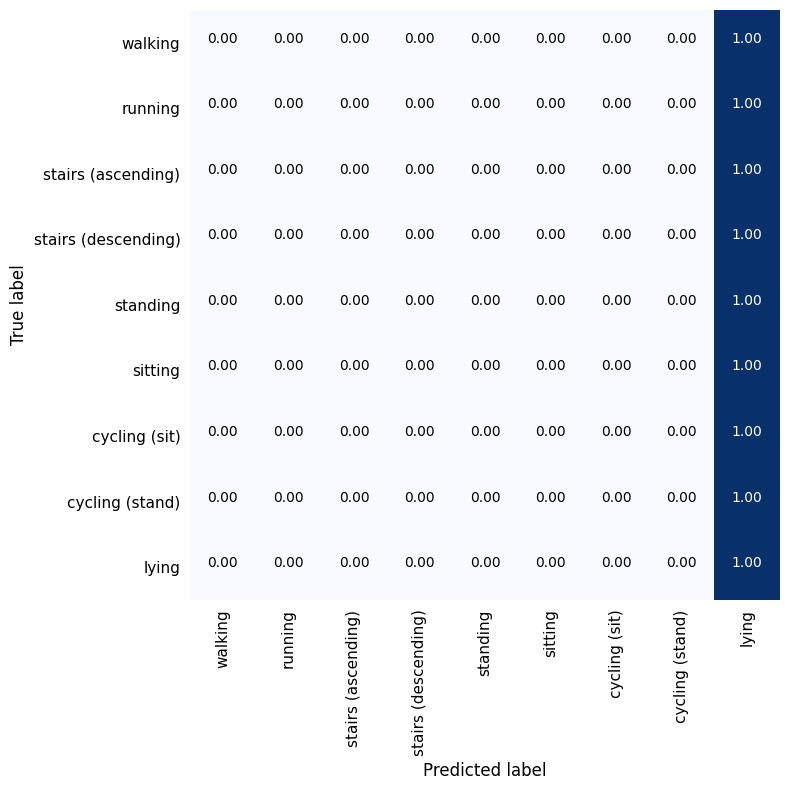

In [ ]:
# fully frozen model
cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]

print("\nCreating the new classifier...")
model = new_classifier(old_model, n_freeze = 14)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print("\nTraining on new data...")

history = model.fit(x=[back_samples[new_train], thigh_samples[new_train]],
                  y=ohe_labels_new_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = ([back_samples[new_val], thigh_samples[new_val]], ohe_labels_new_val),
                  callbacks=[early_stopping])

print("\nSaving model...")
model.save(f"{project_path}/new_model_full")

print("\nPredicting...")
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1)
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)


Creating the new classifier...

Training on new data...
Epoch 1/80
43/43 [==============================] - 4s 21ms/step - loss: 0.2749 - accuracy: 0.9294 - val_loss: 1.5310e-07 - val_accuracy: 1.0000
Epoch 2/80
43/43 [==============================] - 0s 10ms/step - loss: 7.5961e-08 - accuracy: 1.0000 - val_loss: 8.5511e-08 - val_accuracy: 1.0000
Epoch 3/80
43/43 [==============================] - 0s 9ms/step - loss: 6.4103e-08 - accuracy: 1.0000 - val_loss: 8.3758e-08 - val_accuracy: 1.0000
Epoch 4/80
43/43 [==============================] - 0s 9ms/step - loss: 6.1913e-08 - accuracy: 1.0000 - val_loss: 8.2005e-08 - val_accuracy: 1.0000
Epoch 5/80
43/43 [==============================] - 0s 9ms/step - loss: 6.0049e-08 - accuracy: 1.0000 - val_loss: 7.9278e-08 - val_accuracy: 1.0000
Epoch 6/80
43/43 [==============================] - 0s 12ms/step - loss: 5.7990e-08 - accuracy: 1.0000 - val_loss: 7.7525e-08 - val_accuracy: 1.0000
Epoch 7/80
43/43 [==============================] - 1s 1

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

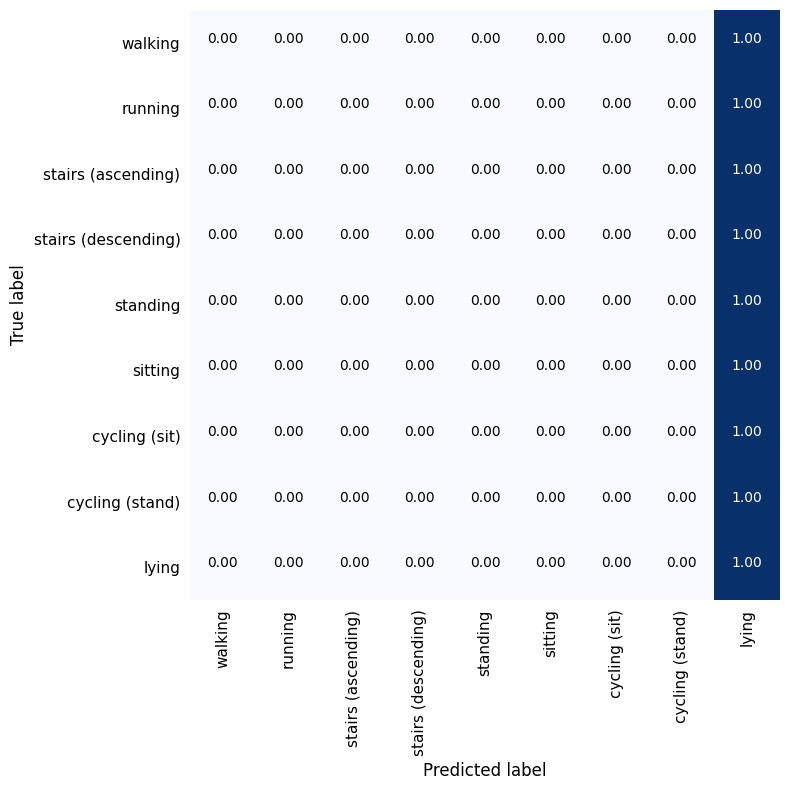

In [ ]:
# partially frozen model

cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]

print("\nCreating the new classifier...")
model = new_classifier(old_model, n_freeze = 6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print("\nTraining on new data...")

history = model.fit(x=[back_samples[new_train], thigh_samples[new_train]],
                  y=ohe_labels_new_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = ([back_samples[new_val], thigh_samples[new_val]], ohe_labels_new_val),
                  callbacks=[early_stopping])

print("\nSaving model...")
model.save(f"{project_path}/new_model_mid")

print("\nPredicting...")
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1)
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)


Creating the new classifier...

Training on new data...
Epoch 1/80
43/43 [==============================] - 3s 21ms/step - loss: 0.0119 - accuracy: 0.9953 - val_loss: 3.8957e-09 - val_accuracy: 1.0000
Epoch 2/80
43/43 [==============================] - 0s 11ms/step - loss: 7.8042e-10 - accuracy: 1.0000 - val_loss: 2.5322e-09 - val_accuracy: 1.0000
Epoch 3/80
43/43 [==============================] - 0s 11ms/step - loss: 5.2028e-10 - accuracy: 1.0000 - val_loss: 2.5322e-09 - val_accuracy: 1.0000
Epoch 4/80
43/43 [==============================] - 0s 10ms/step - loss: 5.2028e-10 - accuracy: 1.0000 - val_loss: 2.5322e-09 - val_accuracy: 1.0000
Epoch 5/80
43/43 [==============================] - 0s 11ms/step - loss: 5.2028e-10 - accuracy: 1.0000 - val_loss: 2.5322e-09 - val_accuracy: 1.0000
Epoch 6/80
43/43 [==============================] - 0s 11ms/step - loss: 5.2028e-10 - accuracy: 1.0000 - val_loss: 2.5322e-09 - val_accuracy: 1.0000
Epoch 7/80
43/43 [==============================] - 0

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

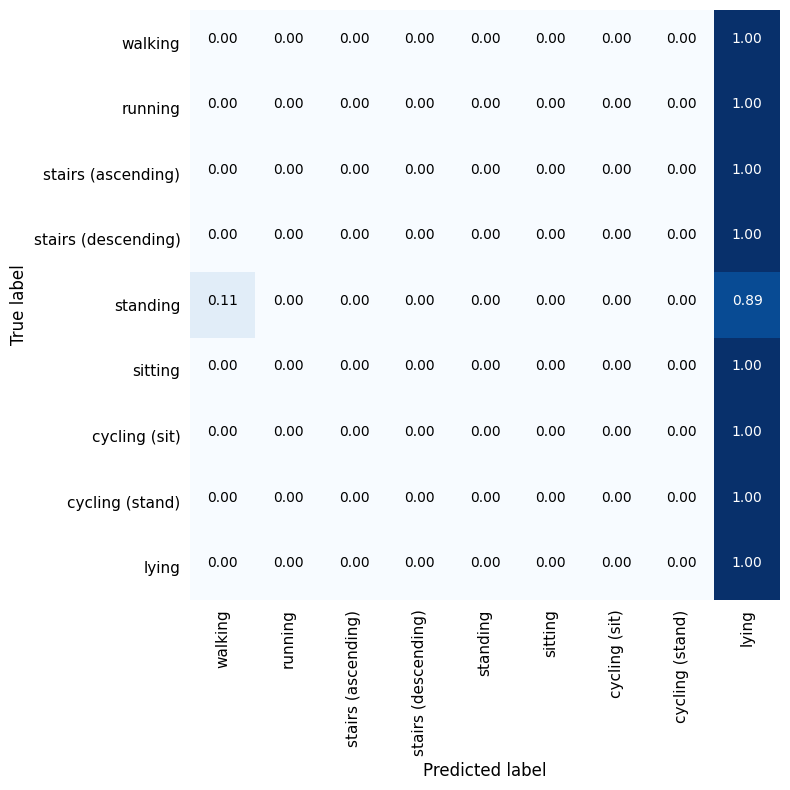

In [ ]:
# trainable model
cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]

print("\nCreating the new classifier...")
model = new_classifier(old_model, n_freeze = 0)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print("\nTraining on new data...")

history = model.fit(x=[back_samples[new_train], thigh_samples[new_train]],
                  y=ohe_labels_new_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = ([back_samples[new_val], thigh_samples[new_val]], ohe_labels_new_val),
                  callbacks=[early_stopping])

print("\nSaving model...")
model.save(f"{project_path}/new_model_free")

print("\nPredicting...")
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1)
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)

What we see here is the phenomenon of catastrophic forgetting (CF) at its fullest: when training on a new class the model completely forgets what it had previously learned. The new model is basically classifying each new testing sample as belonging to the last class it learned.
It's possible to notice how all three models perform poorly, the one with the frozen architecture in particular: this is due to the fact that a model with more frozen layers has less trainable parameters so these will be more heavily affected by the new training.
Also, a model which has only a few layers frozen, like the intermediate one should be able to retain more "general-feature" knowledge, which it extracts from the first layers and then fine tune the last part of the architecture to the new class.

One may argue that CF is due to the fact that the model is being re-trained on a lot of instances of the new class, but it is interesting to see how the same phenomenon presents itself even when the new model is trained on a very small amount of data.

In the next cells training is performed with only 10 (randomly picked) samples of the new class and the results are not much distant from the ones seen above.

In [ ]:
# used in all following cells -> define only once
train_size = 10
random_sample = np.random.choice(new_train.shape[0], train_size, replace=False)
new_train_rs = new_train[random_sample]
ohe_labels_new_train_rs = ohe_labels_new_train[random_sample]

# get validation data
new_train_rs, new_val_rs, ohe_labels_new_train_rs, ohe_labels_new_val_rs = train_test_split(new_train_rs, ohe_labels_new_train_rs, test_size=0.1)


Creating the new classifier...

Training on new data...
Epoch 1/80
1/1 [==============================] - 3s 3s/step - loss: 3.7884 - accuracy: 0.0000e+00 - val_loss: 1.1924 - val_accuracy: 0.0000e+00
Epoch 2/80
1/1 [==============================] - 0s 48ms/step - loss: 1.1521 - accuracy: 0.7778 - val_loss: 0.0771 - val_accuracy: 1.0000
Epoch 3/80
1/1 [==============================] - 0s 44ms/step - loss: 0.2451 - accuracy: 0.8889 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 4/80
1/1 [==============================] - 0s 43ms/step - loss: 0.0225 - accuracy: 1.0000 - val_loss: 3.8736e-04 - val_accuracy: 1.0000
Epoch 5/80
1/1 [==============================] - 0s 47ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 4.4941e-05 - val_accuracy: 1.0000
Epoch 6/80
1/1 [==============================] - 0s 43ms/step - loss: 2.1909e-04 - accuracy: 1.0000 - val_loss: 6.9141e-06 - val_accuracy: 1.0000
Epoch 7/80
1/1 [==============================] - 0s 46ms/step - loss: 4.0039e-05 - acc

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

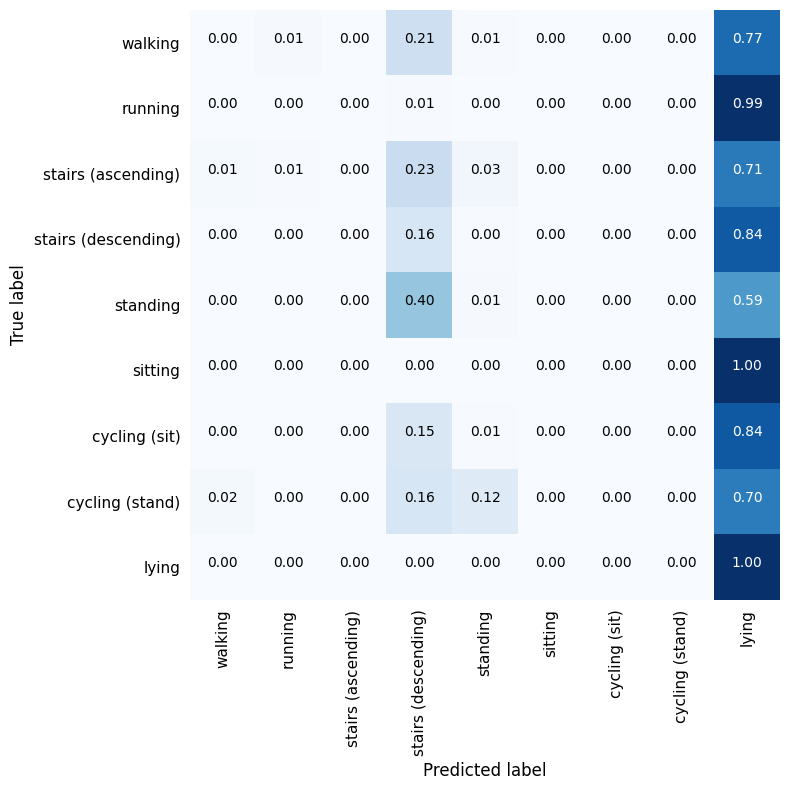

In [ ]:
# model w/o frozen layers -> all trainable

cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]

print("\nCreating the new classifier...")
model = new_classifier(old_model, n_freeze = 0)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print("\nTraining on new data...")

history = model.fit(x=[back_samples[new_train_rs], thigh_samples[new_train_rs]],
                  y=ohe_labels_new_train_rs,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = ([back_samples[new_val_rs], thigh_samples[new_val_rs]], ohe_labels_new_val_rs),
                  callbacks=[early_stopping])

print("\nSaving model...")
model.save(f"{project_path}/new_model_False_10_r")

print("\nPredicting...")
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1)
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)

print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)


Creating the new classifier...

Training on new data...
Epoch 1/80
1/1 [==============================] - 5s 5s/step - loss: 22.0066 - accuracy: 0.0000e+00 - val_loss: 21.0828 - val_accuracy: 0.0000e+00
Epoch 2/80
1/1 [==============================] - 0s 100ms/step - loss: 16.9402 - accuracy: 0.0000e+00 - val_loss: 16.4517 - val_accuracy: 0.0000e+00
Epoch 3/80
1/1 [==============================] - 0s 86ms/step - loss: 12.6052 - accuracy: 0.0000e+00 - val_loss: 12.5764 - val_accuracy: 0.0000e+00
Epoch 4/80
1/1 [==============================] - 0s 80ms/step - loss: 8.8780 - accuracy: 0.0000e+00 - val_loss: 9.5264 - val_accuracy: 0.0000e+00
Epoch 5/80
1/1 [==============================] - 0s 166ms/step - loss: 5.6385 - accuracy: 0.0000e+00 - val_loss: 6.7810 - val_accuracy: 0.0000e+00
Epoch 6/80
1/1 [==============================] - 0s 112ms/step - loss: 2.9101 - accuracy: 0.1111 - val_loss: 4.0493 - val_accuracy: 0.0000e+00
Epoch 7/80
1/1 [==============================] - 0s 182ms

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

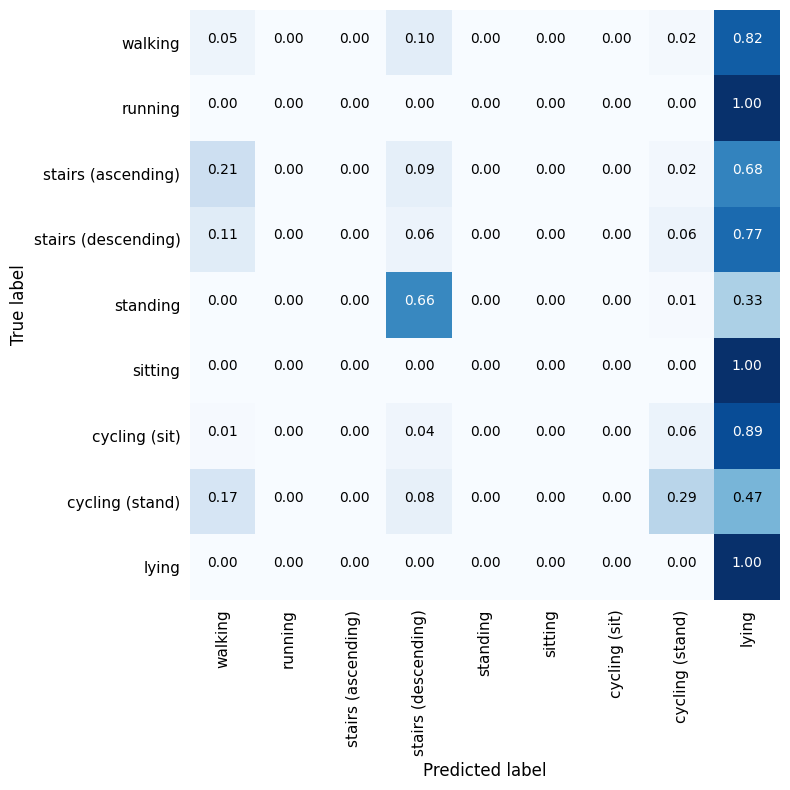

In [ ]:
# model half trainable, half frozen
cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]

print("\nCreating the new classifier...")
model = new_classifier(old_model, n_freeze = 6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print("\nTraining on new data...")

history = model.fit(x=[back_samples[new_train_rs], thigh_samples[new_train_rs]],
                  y=ohe_labels_new_train_rs,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = ([back_samples[new_val_rs], thigh_samples[new_val_rs]], ohe_labels_new_val_rs),
                  callbacks=[early_stopping])

print("\nSaving model...")
model.save(f"{project_path}/new_model_mid_10_r")

print("\nPredicting...")
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1)
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)


Creating the new classifier...

Training on new data...
Epoch 1/80
1/1 [==============================] - 2s 2s/step - loss: 6.0935 - accuracy: 0.0000e+00 - val_loss: 15.7577 - val_accuracy: 0.0000e+00
Epoch 2/80
1/1 [==============================] - 0s 75ms/step - loss: 5.4529 - accuracy: 0.0000e+00 - val_loss: 14.9188 - val_accuracy: 0.0000e+00
Epoch 3/80
1/1 [==============================] - 0s 51ms/step - loss: 4.8154 - accuracy: 0.0000e+00 - val_loss: 14.0801 - val_accuracy: 0.0000e+00
Epoch 4/80
1/1 [==============================] - 0s 43ms/step - loss: 4.1838 - accuracy: 0.0000e+00 - val_loss: 13.2418 - val_accuracy: 0.0000e+00
Epoch 5/80
1/1 [==============================] - 0s 39ms/step - loss: 3.5640 - accuracy: 0.0000e+00 - val_loss: 12.4045 - val_accuracy: 0.0000e+00
Epoch 6/80
1/1 [==============================] - 0s 43ms/step - loss: 2.9664 - accuracy: 0.0000e+00 - val_loss: 11.5695 - val_accuracy: 0.0000e+00
Epoch 7/80
1/1 [==============================] - 0s 42ms

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

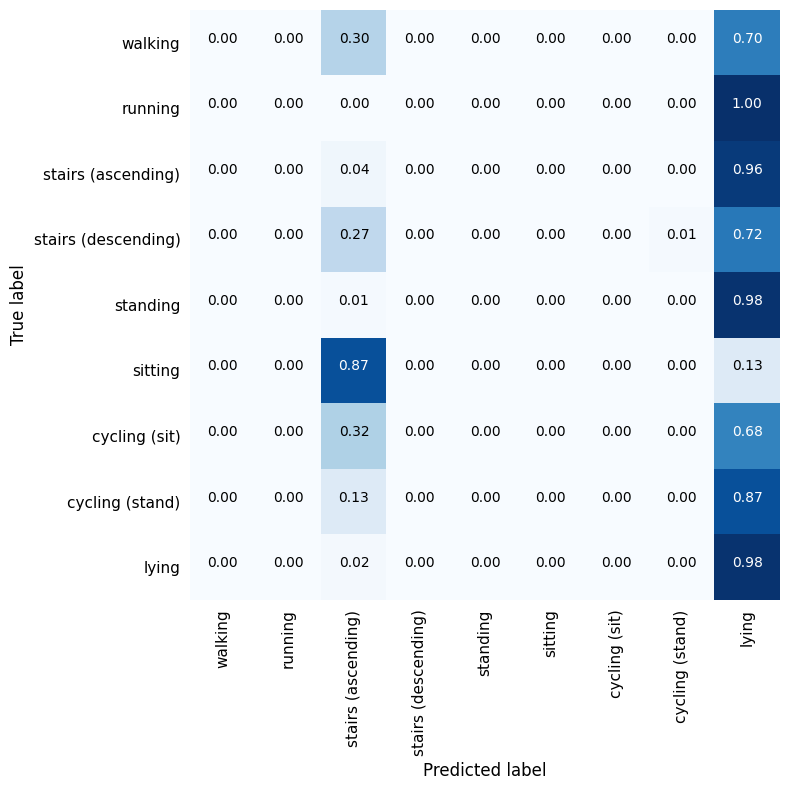

In [ ]:
# completely frozen layers
cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]

print("\nCreating the new classifier...")
model = new_classifier(old_model, n_freeze=14)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print("\nTraining on new data...")

history = model.fit(x=[back_samples[new_train_rs], thigh_samples[new_train_rs]],
                  y=ohe_labels_new_train_rs,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = ([back_samples[new_val_rs], thigh_samples[new_val_rs]], ohe_labels_new_val_rs),
                  callbacks=[early_stopping])

print("\nSaving model...")
model.save(f"{project_path}/new_model_True_10_r")

print("\nPredicting...")
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1)
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)

### Replay methods
In this section I implemented two techniques to mitigate the problem of catastrophic forgetting: random replay and iCARL-inspired replay.

#### Random replay

Let's start with random replay which is the simplest way of performing continual learning.

This technique makes the new model (the one used for 9-activities classification) "reahrse" what the old model learned about the 8 old classes by adding some randomly picked old training examples (which will constitute the so called buffer) to the new training set.
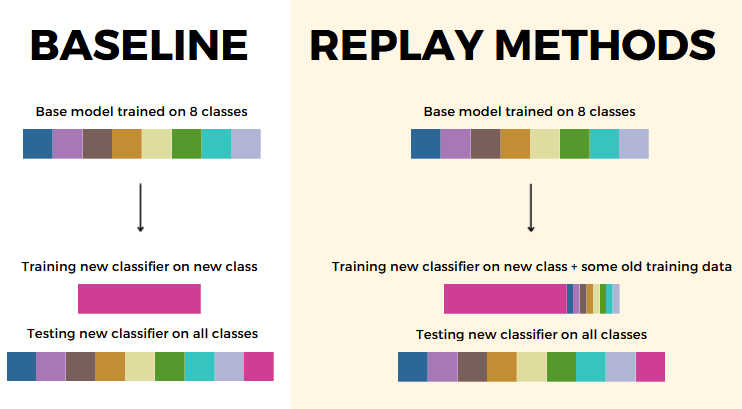

I have decided to use class-balanced buffers i.e. to create buffers of rehearsal examples which contain the same number of examples for each class.

In [ ]:
with open(f"/content/drive/MyDrive/ColabData/AmID/replay/red_train_test_split.txt", "rb") as f:
  data = pickle.load(f)   # re-load test train split for both old & new data

old_train = data['old_train']
old_test = data['old_test']
lab_old_train = data['lab_old_train']
lab_old_test = data['lab_old_test']
new_train = data['new_train']
new_test = data['new_test']
lab_new_train = data['lab_new_train']
lab_new_test = data['lab_new_test']

del data

This function selects in a random way a fixed number (class_size) of indices of samples from each old class and adds it into an array, which will later be used to select the corresponding samples and adding them to the training set (which otherwise would contain only data from the new class, as in the baseline).

In [ ]:
old_lab = [1, 2, 4, 5, 6, 7, 13, 14]

def create_buffer(class_size):
  # class size = number of examples to be replayed for each class
  buff_size = class_size * len(classes_names_old)

  buffer_ex, buffer_lab = [], []

  for lab in old_lab:
    # get the indices that refer only the data samples of the considered labels
    single_lab = (lab_old_train == lab)
    # select random class_size indices of the old_train set -> these will be the indices of elements in the buffer
    buff_sample = np.random.choice(old_train[single_lab], class_size, replace=False)
    # add them to the buffer_ex array ; add to the label array the corresp. labels
    buffer_ex.append(buff_sample)
    buffer_lab.append(labels[buff_sample])

  buffer_ex = np.hstack(buffer_ex)
  buffer_lab = np.hstack(buffer_lab)

  enc = OneHotEncoder(sparse=False) # here sparse = False BC buffer labels' OHE have size 8 but I'll need to expand it to 9
                                    # in order to add them to the OHE of new class labels which have size 9
  ohe_labels_buffer = enc.fit_transform(buffer_lab.reshape(-1,1))

  return buffer_ex, ohe_labels_buffer

Here I defined some parameters for training which will be used in all the following celles; I have also created one hot encoding of labels and loaded the old model.

In [ ]:
enc = OneHotEncoder()
ohe_labels_old_train = enc.fit_transform(labels[old_train].reshape(-1,1)).toarray()
ohe_labels_old_test = enc.fit_transform(labels[old_test].reshape(-1,1)).toarray()

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

n_epochs = 80
batch_size = 128

enc = OneHotEncoder(categories=[range(len(classes_names))], sparse=False)
ohe_labels_new_train = enc.fit_transform(labels[new_train].reshape(-1,1))
ohe_labels_new_test = enc.fit_transform(labels[new_test].reshape(-1,1))

print("Loading the pre-trained model...")
old_model = tf.keras.models.load_model(f"{project_path}/old_model_r")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Loading the pre-trained model...


In the following cells I have trained the "new classifier" with data from the new class and an increasing number of old data.
The performance becomes good even when adding as little as 5 samples for class, but it gets better when considering an higher number.


Creating the new classifier...

Training on new data...
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


48/48 [==============================] - 4s 23ms/step - loss: 0.8269 - accuracy: 0.9041 - val_loss: 3.1029e-08 - val_accuracy: 1.0000
Epoch 2/80
48/48 [==============================] - 1s 14ms/step - loss: 0.0059 - accuracy: 0.9992 - val_loss: 9.4995e-07 - val_accuracy: 1.0000
Epoch 3/80
48/48 [==============================] - 1s 13ms/step - loss: 8.6143e-04 - accuracy: 0.9997 - val_loss: 1.0947e-06 - val_accuracy: 1.0000
Epoch 4/80
48/48 [==============================] - 1s 13ms/step - loss: 2.2768e-05 - accuracy: 1.0000 - val_loss: 8.8873e-07 - val_accuracy: 1.0000
Epoch 5/80
48/48 [==============================] - 1s 13ms/step - loss: 1.6032e-05 - accuracy: 1.0000 - val_loss: 7.3028e-07 - val_accuracy: 1.0000
Epoch 6/80
48/48 [==============================] - 1s 13ms/step - loss: 1.1488e-05 - accuracy: 1.0000 - val_loss: 5.7129e-07 - val_accuracy: 1.0000

Saving model...

Predicting...
586/586 [==============================] - 3s 4ms/step

Classification Report:
              

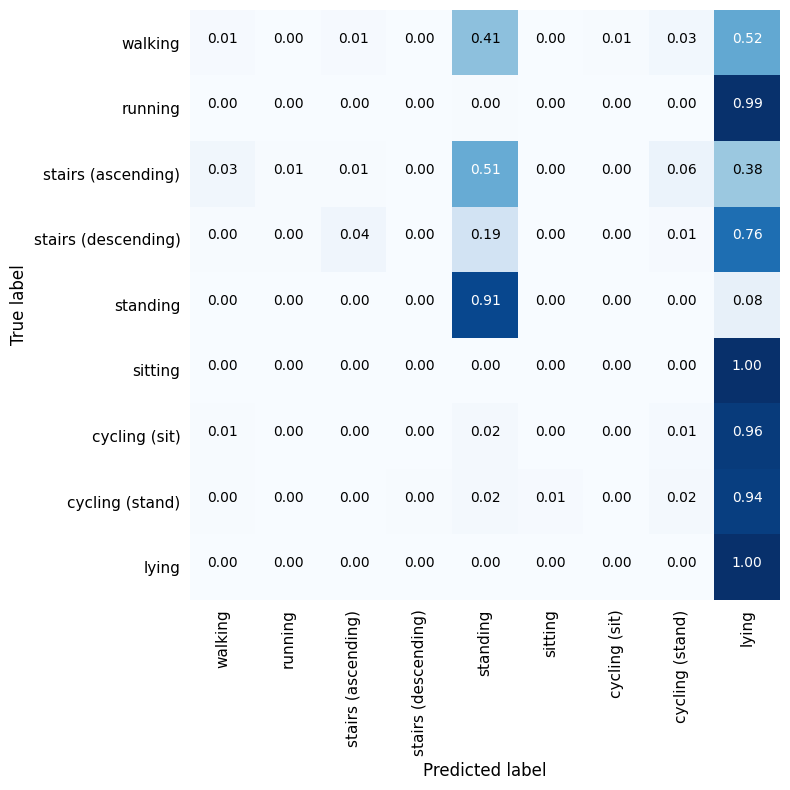

In [ ]:
# all data + 1 x buffer

cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]
# create buffer
buffer_ex, ohe_labels_buffer = create_buffer(class_size = 1)

train_rehearse = np.concatenate((buffer_ex, new_train), axis=0)

# adapt size of OHE buffer to one of training
z = np.zeros((ohe_labels_buffer.shape[0],1))
z = np.concatenate((ohe_labels_buffer, z), axis = 1)
ohe_train = np.concatenate((z, ohe_labels_new_train), axis=0)

# get validation data
train_rehearse, val_tr, ohe_train, ohe_val_tr = train_test_split(train_rehearse, ohe_train, test_size=0.1)

print("\nCreating the new classifier...")
model = new_classifier(old_model, n_freeze = 6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print("\nTraining on new data...")

history = model.fit(x=[back_samples[train_rehearse], thigh_samples[train_rehearse]],
                  y=ohe_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = ([back_samples[val_tr], thigh_samples[val_tr]], ohe_val_tr),
                  callbacks=[early_stopping])

print("\nSaving model...")
model.save(f"{project_path}/random_1_mid") #random _ xbuffer _ type of model

print("\nPredicting...")
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1)
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)

overall_accuracy = accuracy_score(y_targets, y_preds) # save overall accuracy; this will be used later x a graph
with open('/content/drive/MyDrive/ColabData/AmID/replay/random_1_mid_acc.pkl', 'wb') as file:
    pickle.dump(overall_accuracy, file)



Creating the new classifier...

Training on new data...
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


49/49 [==============================] - 7s 26ms/step - loss: 0.2645 - accuracy: 0.9309 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 2/80
49/49 [==============================] - 1s 13ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 3/80
49/49 [==============================] - 1s 13ms/step - loss: 5.3195e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 4/80
49/49 [==============================] - 1s 13ms/step - loss: 2.0301e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 5/80
49/49 [==============================] - 1s 12ms/step - loss: 8.9442e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 6/80
49/49 [==============================] - 1s 12ms/step - loss: 5.5838e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 7/80
49/49 [==============================] - 1s 12ms/step - loss: 3.8052e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9985
Epoc

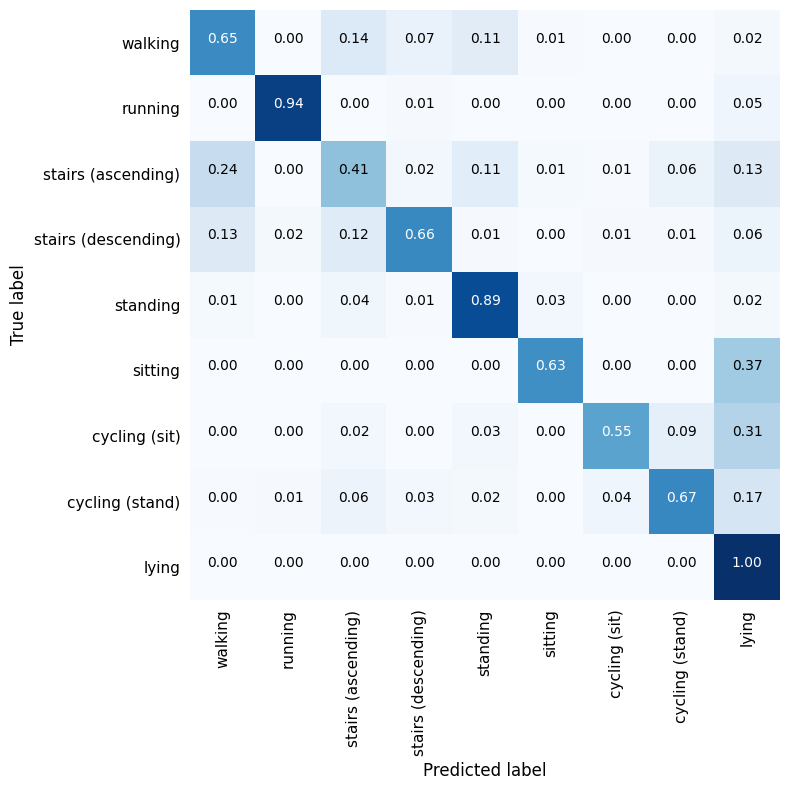

In [ ]:
# all data + 5 x buffer
# half frozen model

cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]
# create buffer
buffer_ex, ohe_labels_buffer = create_buffer(class_size = 5)

train_rehearse = np.concatenate((buffer_ex, new_train), axis=0)

# adapt size of OHE buffer to one of training
z = np.zeros((ohe_labels_buffer.shape[0],1))
z = np.concatenate((ohe_labels_buffer, z), axis = 1)
ohe_train = np.concatenate((z, ohe_labels_new_train), axis=0)

# get validation data
train_rehearse, val_tr, ohe_train, ohe_val_tr = train_test_split(train_rehearse, ohe_train, test_size=0.1)

print("\nCreating the new classifier...")
model = new_classifier(old_model, n_freeze = 6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print("\nTraining on new data...")

history = model.fit(x=[back_samples[train_rehearse], thigh_samples[train_rehearse]],
                  y=ohe_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = ([back_samples[val_tr], thigh_samples[val_tr]], ohe_val_tr),
                  callbacks=[early_stopping])

print("\nSaving model...")
model.save(f"{project_path}/random_5_mid") #random _ xbuffer _ type of model

print("\nPredicting...")
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1)
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))
cl = classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0)

print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)

overall_accuracy = accuracy_score(y_targets, y_preds)
with open('/content/drive/MyDrive/ColabData/AmID/replay/random_5_mid_acc.pkl', 'wb') as file:
    pickle.dump(overall_accuracy, file)


Creating the new classifier...

Training on new data...
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


49/49 [==============================] - 4s 30ms/step - loss: 0.1283 - accuracy: 0.9677 - val_loss: 0.0307 - val_accuracy: 0.9942
Epoch 2/80
49/49 [==============================] - 1s 13ms/step - loss: 0.0063 - accuracy: 0.9979 - val_loss: 0.0389 - val_accuracy: 0.9927
Epoch 3/80
49/49 [==============================] - 1s 12ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0300 - val_accuracy: 0.9927
Epoch 4/80
49/49 [==============================] - 1s 13ms/step - loss: 0.0027 - accuracy: 0.9989 - val_loss: 0.0338 - val_accuracy: 0.9942
Epoch 5/80
49/49 [==============================] - 1s 13ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.0325 - val_accuracy: 0.9942
Epoch 6/80
49/49 [==============================] - 1s 13ms/step - loss: 7.7198e-04 - accuracy: 0.9998 - val_loss: 0.0334 - val_accuracy: 0.9942
Epoch 7/80
49/49 [==============================] - 1s 13ms/step - loss: 5.1418e-04 - accuracy: 0.9998 - val_loss: 0.0360 - val_accuracy: 0.9942
Epoch 8/80
49/49

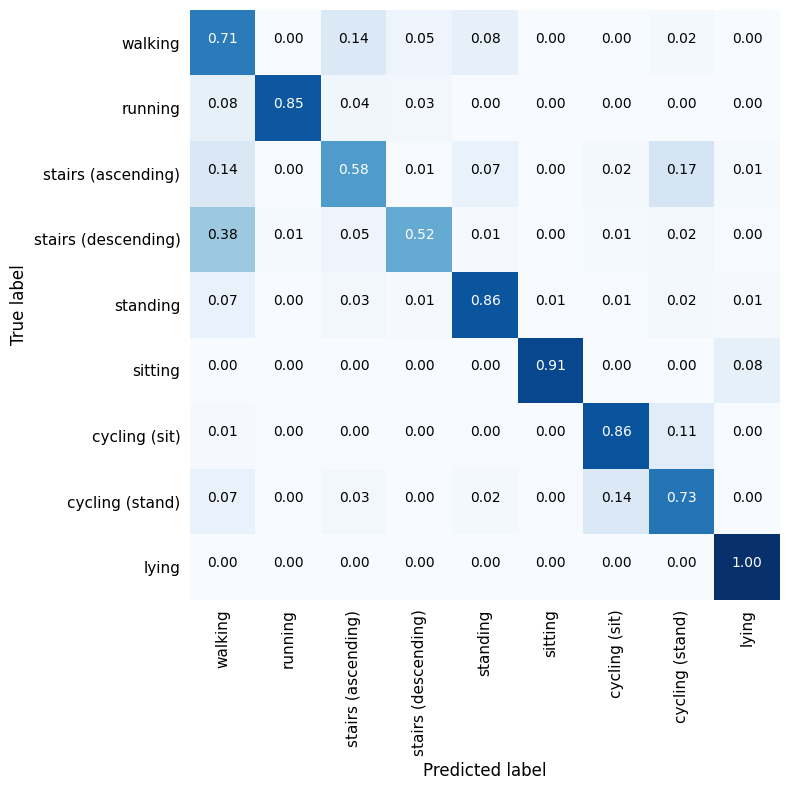

In [ ]:
# all data + 10 x buffer
# half frozen model

cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]
# create buffer
buffer_ex, ohe_labels_buffer = create_buffer(class_size = 10)

train_rehearse = np.concatenate((buffer_ex, new_train), axis=0)

# adapt size of OHE buffer to one of training
z = np.zeros((ohe_labels_buffer.shape[0],1))
z = np.concatenate((ohe_labels_buffer, z), axis = 1)
ohe_train = np.concatenate((z, ohe_labels_new_train), axis=0)

# get validation data
train_rehearse, val_tr, ohe_train, ohe_val_tr = train_test_split(train_rehearse, ohe_train, test_size=0.1)

print("\nCreating the new classifier...")
model = new_classifier(old_model, n_freeze = 6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print("\nTraining on new data...")

history = model.fit(x=[back_samples[train_rehearse], thigh_samples[train_rehearse]],
                  y=ohe_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = ([back_samples[val_tr], thigh_samples[val_tr]], ohe_val_tr),
                  callbacks=[early_stopping])

print("\nSaving model...")
model.save(f"{project_path}/random_10_mid") #random _ xbuffer _ type of model

print("\nPredicting...")
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1)
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))
cl = classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0)

print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)

overall_accuracy = accuracy_score(y_targets, y_preds)
with open('/content/drive/MyDrive/ColabData/AmID/replay/random_10_mid_acc.pkl', 'wb') as file:
    pickle.dump(overall_accuracy, file)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Creating the new classifier...

Training on new data...
Epoch 1/80
49/49 [==============================] - 6s 24ms/step - loss: 0.4034 - accuracy: 0.9151 - val_loss: 0.0304 - val_accuracy: 0.9914
Epoch 2/80
49/49 [==============================] - 1s 13ms/step - loss: 0.0153 - accuracy: 0.9950 - val_loss: 0.0189 - val_accuracy: 0.9943
Epoch 3/80
49/49 [==============================] - 1s 13ms/step - loss: 0.0071 - accuracy: 0.9982 - val_loss: 0.0162 - val_accuracy: 0.9928
Epoch 4/80
49/49 [==============================] - 1s 13ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.0160 - val_accuracy: 0.9928
Epoch 5/80
49/49 [==============================] - 1s 13ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0147 - val_accuracy: 0.9943
Epoch 6/80
49/49 [==============================] - 1s 12ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0146 - val_accuracy: 0.9928
Epoch 7/80
49/49 [==============================] - 1s 12ms/step - loss: 6.6687e-04 - accuracy: 0

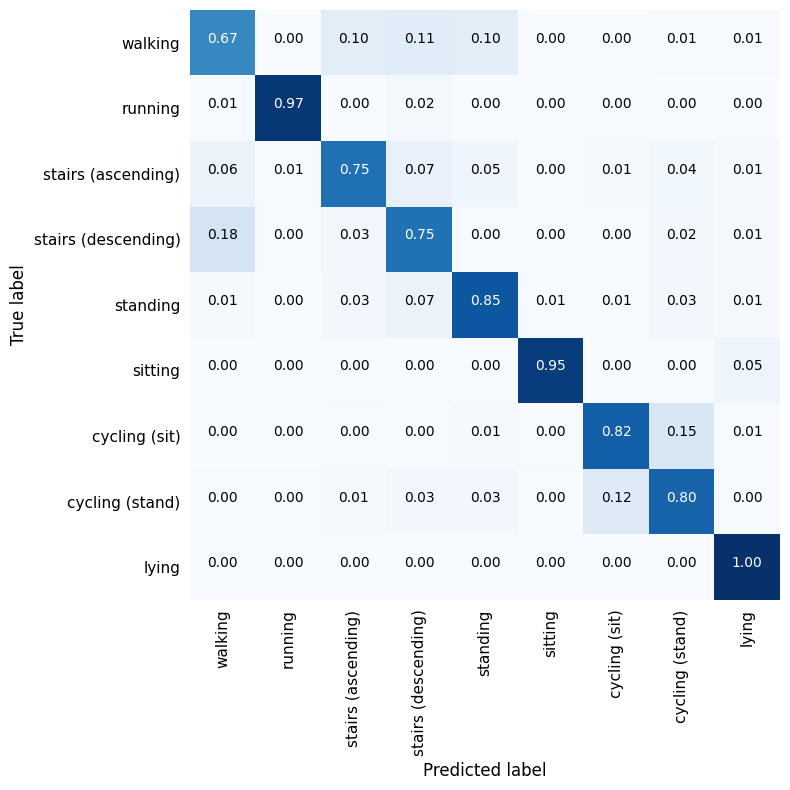

In [ ]:
# all data + 20 x buffer
# half frozen model

cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]
# create buffer
buffer_ex, ohe_labels_buffer = create_buffer(class_size = 20)

train_rehearse = np.concatenate((buffer_ex, new_train), axis=0)

# adapt size of OHE buffer to one of training
z = np.zeros((ohe_labels_buffer.shape[0],1))
z = np.concatenate((ohe_labels_buffer, z), axis = 1)
ohe_train = np.concatenate((z, ohe_labels_new_train), axis=0)

# get validation data
train_rehearse, val_tr, ohe_train, ohe_val_tr = train_test_split(train_rehearse, ohe_train, test_size=0.1)

print("\nCreating the new classifier...")
model = new_classifier(old_model, n_freeze = 6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print("\nTraining on new data...")

history = model.fit(x=[back_samples[train_rehearse], thigh_samples[train_rehearse]],
                  y=ohe_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = ([back_samples[val_tr], thigh_samples[val_tr]], ohe_val_tr),
                  callbacks=[early_stopping])

print("\nSaving model...")
model.save(f"{project_path}/random_20_mid") #random _ xbuffer _ type of model

print("\nPredicting...")
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1)
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))
cl = classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0)

print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)

overall_accuracy = accuracy_score(y_targets, y_preds)
with open('/content/drive/MyDrive/ColabData/AmID/replay/random_20_mid_acc.pkl', 'wb') as file:
    pickle.dump(overall_accuracy, file)


Creating the new classifier...

Training on new data...
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


51/51 [==============================] - 4s 28ms/step - loss: 0.2216 - accuracy: 0.9498 - val_loss: 0.0948 - val_accuracy: 0.9792
Epoch 2/80
51/51 [==============================] - 1s 13ms/step - loss: 0.0236 - accuracy: 0.9940 - val_loss: 0.0845 - val_accuracy: 0.9847
Epoch 3/80
51/51 [==============================] - 1s 13ms/step - loss: 0.0124 - accuracy: 0.9972 - val_loss: 0.0802 - val_accuracy: 0.9847
Epoch 4/80
51/51 [==============================] - 1s 13ms/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.0840 - val_accuracy: 0.9847
Epoch 5/80
51/51 [==============================] - 1s 12ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 0.0769 - val_accuracy: 0.9833
Epoch 6/80
51/51 [==============================] - 1s 16ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.0778 - val_accuracy: 0.9847
Epoch 7/80
51/51 [==============================] - 1s 17ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0829 - val_accuracy: 0.9833
Epoch 8/80
51/51 [======

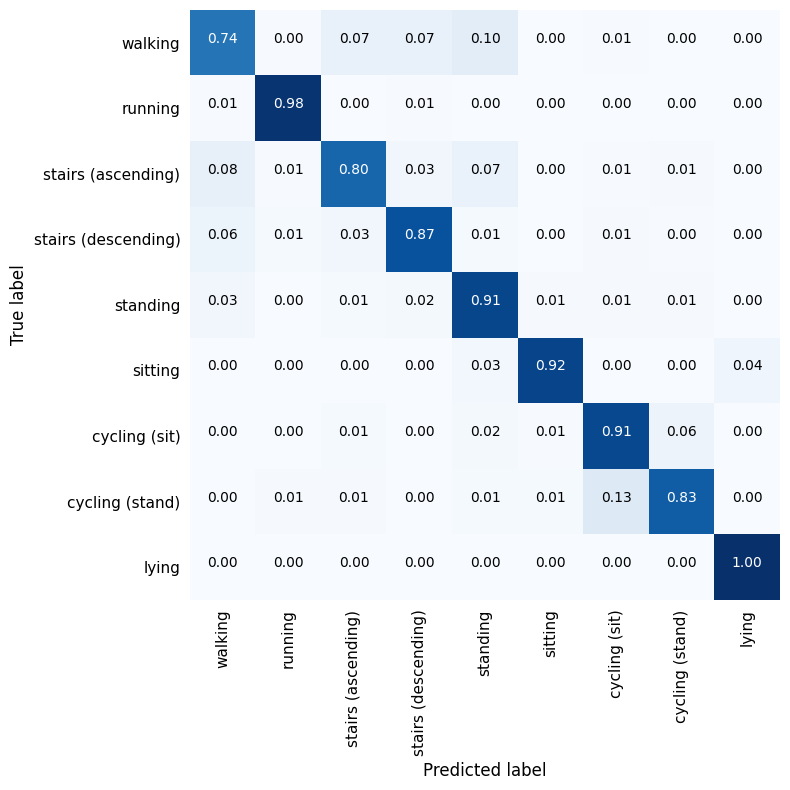

In [ ]:
# all data + 50 x buffer

cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]
# create buffer
buffer_ex, ohe_labels_buffer = create_buffer(class_size = 50)

train_rehearse = np.concatenate((buffer_ex, new_train), axis=0)

# adapt size of OHE buffer to one of training
z = np.zeros((ohe_labels_buffer.shape[0],1))
z = np.concatenate((ohe_labels_buffer, z), axis = 1)
ohe_train = np.concatenate((z, ohe_labels_new_train), axis=0)

# get validation data
train_rehearse, val_tr, ohe_train, ohe_val_tr = train_test_split(train_rehearse, ohe_train, test_size=0.1)

print("\nCreating the new classifier...")
model = new_classifier(old_model, n_freeze = 6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print("\nTraining on new data...")

history = model.fit(x=[back_samples[train_rehearse], thigh_samples[train_rehearse]],
                  y=ohe_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = ([back_samples[val_tr], thigh_samples[val_tr]], ohe_val_tr),
                  callbacks=[early_stopping])

print("\nSaving model...")
model.save(f"{project_path}/random_50_mid") #random _ xbuffer _ type of model

print("\nPredicting...")
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1)
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)

overall_accuracy = accuracy_score(y_targets, y_preds)
with open('/content/drive/MyDrive/ColabData/AmID/replay/random_50_mid_acc.pkl', 'wb') as file:
    pickle.dump(overall_accuracy, file)


Let's now have an overview of the obtained results.


Text(0.5, 1.0, 'Summary random replay with half-frozen model')

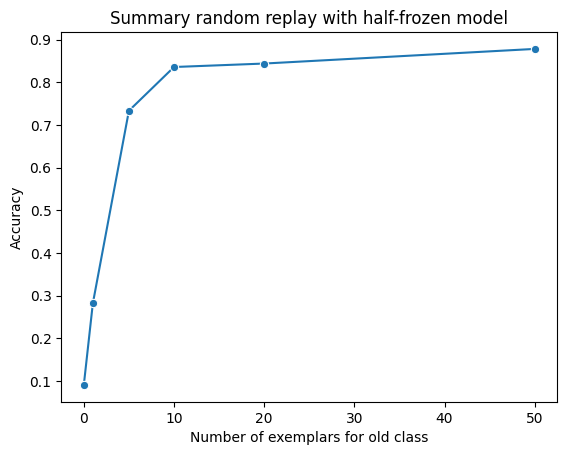

In [ ]:
num_exempl = [0, 1, 5, 10, 20, 50]
accuracy_random = np.zeros((1, len(num_exempl)))[0]
accuracy_random[0] = 0.0907 # accuracy of half-frozen model w/o use of replay technique (baseline)
base_path = '/content/drive/MyDrive/ColabData/AmID/replay/'

for idx in range(1, len(num_exempl)):
    file_path = os.path.join(base_path, f'random_{num_exempl[idx]}_mid_acc.pkl')

    # Check if the file exists before attempting to load it
    if os.path.exists(file_path):
        with open(file_path, 'rb') as file:
            accuracy_random[idx]= pickle.load(file)

#sns.scatterplot(x=num_exempl, y=accuracy_iCaRL)
sns.lineplot(x=num_exempl, y=accuracy_random, marker='o')
# Set plot labels and title
plt.xlabel('Number of exemplars for old class')
plt.ylabel('Accuracy')
plt.title('Summary random replay with half-frozen model')

The performance of the model, as expected, increases as the number of examples from the old classes is increased.
Using 10 samples from each of the old classes seems to be a good choice for having a good result without adding too many samples to the training set.

##### Comparison of different type of models
Testing the difference between fully frozen, half frozen and trainable models.

Here I've also presented the results obtained with the fully frozen feature extracttor and with the completely trainable architecture. The results are not too far from what was seen for the half-frozen model trained with the same number (10) of examples for class.


Creating the new classifier...

Training on new data...
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


49/49 [==============================] - 1s 12ms/step - loss: 0.5491 - accuracy: 0.8192 - val_loss: 0.0482 - val_accuracy: 0.9869
Epoch 2/80
49/49 [==============================] - 1s 12ms/step - loss: 0.0474 - accuracy: 0.9893 - val_loss: 0.0321 - val_accuracy: 0.9898
Epoch 3/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0305 - accuracy: 0.9919 - val_loss: 0.0234 - val_accuracy: 0.9942
Epoch 4/80
49/49 [==============================] - 1s 10ms/step - loss: 0.0215 - accuracy: 0.9940 - val_loss: 0.0189 - val_accuracy: 0.9956
Epoch 5/80
49/49 [==============================] - 1s 10ms/step - loss: 0.0163 - accuracy: 0.9960 - val_loss: 0.0160 - val_accuracy: 0.9956
Epoch 6/80
49/49 [==============================] - 0s 10ms/step - loss: 0.0129 - accuracy: 0.9969 - val_loss: 0.0138 - val_accuracy: 0.9956
Epoch 7/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0105 - accuracy: 0.9981 - val_loss: 0.0129 - val_accuracy: 0.9956
Epoch 8/80
49/49 [======

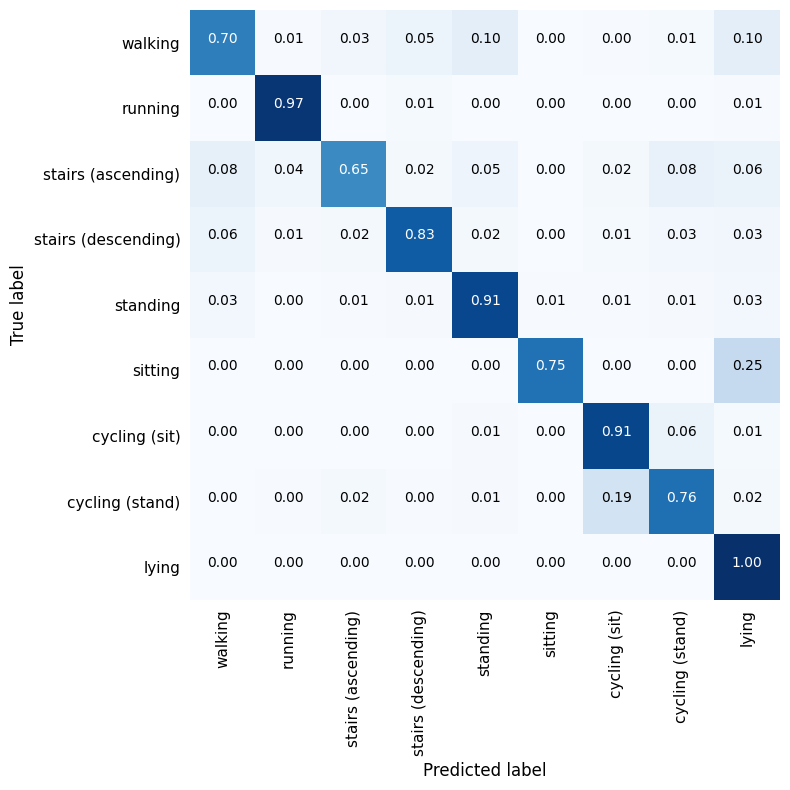

In [ ]:
# all data + 10 x buffer
# fully frozen model

cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]
# create buffer
buffer_ex, ohe_labels_buffer = create_buffer(class_size = 10)

train_rehearse = np.concatenate((buffer_ex, new_train), axis=0)

# adapt size of OHE buffer to one of training
z = np.zeros((ohe_labels_buffer.shape[0],1))
z = np.concatenate((ohe_labels_buffer, z), axis = 1)
ohe_train = np.concatenate((z, ohe_labels_new_train), axis=0)

# get validation data
train_rehearse, val_tr, ohe_train, ohe_val_tr = train_test_split(train_rehearse, ohe_train, test_size=0.1)

print("\nCreating the new classifier...")
model = new_classifier(old_model, n_freeze = 14)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print("\nTraining on new data...")

history = model.fit(x=[back_samples[train_rehearse], thigh_samples[train_rehearse]],
                  y=ohe_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = ([back_samples[val_tr], thigh_samples[val_tr]], ohe_val_tr),
                  callbacks=[early_stopping])

print("\nSaving model...")
model.save(f"{project_path}/random_10_full") #random _ xbuffer _ type of model

print("\nPredicting...")
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1)
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))
cl = classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0)

print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)

overall_accuracy = accuracy_score(y_targets, y_preds)
with open('/content/drive/MyDrive/ColabData/AmID/replay/random_10_full_acc.pkl', 'wb') as file:
    pickle.dump(overall_accuracy, file)


Creating the new classifier...

Training on new data...
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


49/49 [==============================] - 5s 21ms/step - loss: 0.3494 - accuracy: 0.9196 - val_loss: 0.0144 - val_accuracy: 0.9942
Epoch 2/80
49/49 [==============================] - 0s 9ms/step - loss: 0.0121 - accuracy: 0.9961 - val_loss: 0.0104 - val_accuracy: 0.9971
Epoch 3/80
49/49 [==============================] - 0s 9ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0133 - val_accuracy: 0.9942
Epoch 4/80
49/49 [==============================] - 1s 10ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.0101 - val_accuracy: 0.9942
Epoch 5/80
49/49 [==============================] - 0s 9ms/step - loss: 5.8183e-04 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 0.9971
Epoch 6/80
49/49 [==============================] - 0s 10ms/step - loss: 3.2203e-04 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 0.9971
Epoch 7/80
49/49 [==============================] - 0s 9ms/step - loss: 2.1969e-04 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 0.9971
Epoch 8/80
49/49

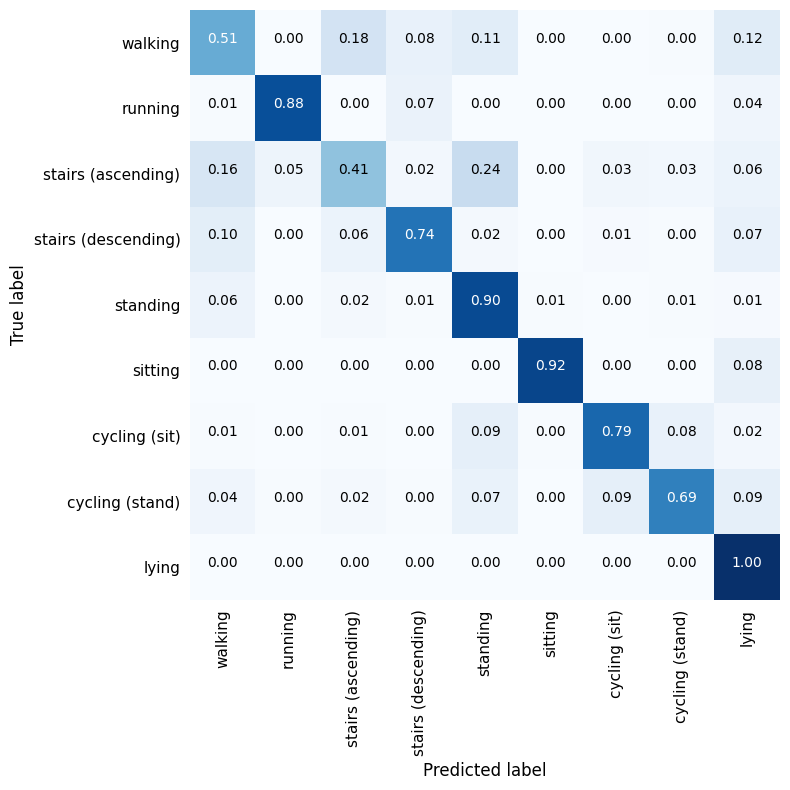

In [ ]:
# all data + 10 x buffer
# completely trainable model

cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]
# create buffer
buffer_ex, ohe_labels_buffer = create_buffer(class_size = 10)

train_rehearse = np.concatenate((buffer_ex, new_train), axis=0)

# adapt size of OHE buffer to one of training
z = np.zeros((ohe_labels_buffer.shape[0],1))
z = np.concatenate((ohe_labels_buffer, z), axis = 1)
ohe_train = np.concatenate((z, ohe_labels_new_train), axis=0)

# get validation data
train_rehearse, val_tr, ohe_train, ohe_val_tr = train_test_split(train_rehearse, ohe_train, test_size=0.1)

print("\nCreating the new classifier...")
model = new_classifier(old_model, n_freeze = 6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print("\nTraining on new data...")

history = model.fit(x=[back_samples[train_rehearse], thigh_samples[train_rehearse]],
                  y=ohe_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = ([back_samples[val_tr], thigh_samples[val_tr]], ohe_val_tr),
                  callbacks=[early_stopping])

print("\nSaving model...")
model.save(f"{project_path}/random_10_free") #random _ xbuffer _ type of model

print("\nPredicting...")
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1)
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))
cl = classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0)

print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)

overall_accuracy = accuracy_score(y_targets, y_preds)
with open('/content/drive/MyDrive/ColabData/AmID/replay/random_10_free_acc.pkl', 'wb') as file:
    pickle.dump(overall_accuracy, file)

Text(0.5, 1.0, 'Summary 10 examples random replay')

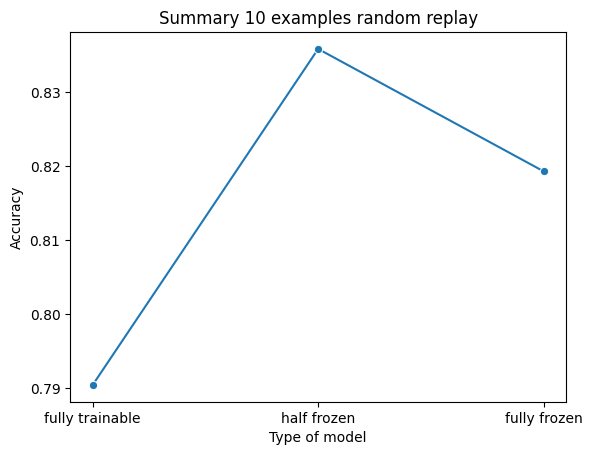

In [ ]:
type_of_model = ['free', 'mid', 'full']
accuracy_random_m = np.zeros((1, len(type_of_model)))[0]
base_path = '/content/drive/MyDrive/ColabData/AmID/replay/'

for idx in range(0, len(type_of_model)):
    file_path = os.path.join(base_path, f'random_10_{type_of_model[idx]}_acc.pkl')

    # Check if the file exists before attempting to load it
    if os.path.exists(file_path):
        with open(file_path, 'rb') as file:
            accuracy_random_m[idx]= pickle.load(file)

#sns.scatterplot(x=num_exempl, y=accuracy_iCaRL)
sns.lineplot(x=['fully trainable', 'half frozen', 'fully frozen'], y=accuracy_random_m, marker='o')
# Set plot labels and title
plt.xlabel('Type of model')
plt.ylabel('Accuracy')
plt.title('Summary 10 examples random replay')

The overall accuracy of the model is higher when leaving part of the weights trainable and freezing the first layers. This may be due to the fact that the model is retaining general knowledge through the fixed weights of the first layers (which extract less specific features) but still has the freedom of adapting part of its parameters with information from the new class.

#### iCaRL inspired exemplar selection


In this section I tried to implement a way to pick more thoughtfully the examples that are put in the buffer for rehearsal.

The model implemented below works exactly as the one of random replay, the only thing that changes is the way the buffer is created.

The creation of the buffer, which will now be called exemplar set, is inspired by the iCaRL algorithm: the pseudo-code is shown here.


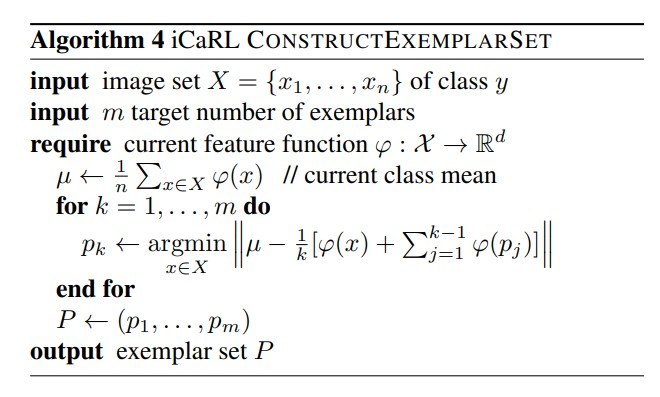

I'm creating a class-balanced exemplar set also in this case; for each class, exemplars are picked as the ones whose feature are closest to the mean of the features of the class. This is done by picking the elements which minimize the L2 norm of the mean of features minus the feature of the element and a penality term. Such penality term is the sum of the features of the previously picked exemplars and it is added to avoid picking the same exemplar more than one time; in this way by adding new exemplars more (old) knowledge is actually added to the training.

Let's start by loading the model which was trained on 8 classes and creating the new classifier with the "half frozen, half trainable" structure.

In [ ]:
print("Loading the pre-trained model...")
old_model = tf.keras.models.load_model(f"{project_path}/old_model_r")

# Create the new classifier
print("\nCreating the new classifier...")
model = new_classifier(old_model, n_freeze = 6)

old_lab = [1, 2, 4, 5, 6, 7, 13, 14]

Loading the pre-trained model...

Creating the new classifier...


The following function is the implementation of the pseudo-code presented above.

In [ ]:
def construct_class_exem(class_back_samples, class_thigh_samples, class_label, num_exe_class, feature_function):
  exemplars = np.zeros(num_exe_class+1) # these will be the indices of exempl

  phi_class = feature_function.predict([class_back_samples, class_thigh_samples])
  mu= np.mean(phi_class, axis=0) # mean of features x this class
  mu_mat = np.tile(mu, (class_back_samples.shape[0], 1)) # create a matrix with num_classes row
                                                         # in each row -> phi_x ; this makes next op easier
  for k in range(num_exe_class):
    if k == 0 :
      vett = mu_mat - (phi_class)/(k+1) # to min -> find first exemplar
    else :
      sum = np.sum(phi_class[exemplars[0:k+1].astype(int)], axis = 0)  # penalization linked to previously picked exemplars
      vett = mu_mat - (phi_class+ np.tile(sum, (class_back_samples.shape[0], 1)))/(k+1) # to min -> find other exemplars

    exemplars[k] = np.argmin(np.linalg.norm((vett), axis = 1))

  exemplar_set = np.concatenate((class_back_samples[exemplars[:-1].astype(int)], class_thigh_samples[exemplars[:-1].astype(int)]), axis = 2)
  exemplar_lab = np.ones((1,num_exe_class))[0]*class_label

  return exemplar_set, exemplar_lab

The "feature function" in my case is the output of the base model before the classification layer i.e. the output of the layer that was called "concatenate".

In [ ]:
num_exe_class =  10 #1 #50 #10  hyperparam -> select num of exemplar in each class (balanced set!)

exemplar_set = []
exemplar_lab = []

layer_output=old_model.get_layer('concatenate').output  #get the Output of the Layer -> use model w/ 8 classes
feature_map_old=tf.keras.models.Model(inputs=old_model.input,outputs=layer_output) #Intermediate model between Input Layer and Output Layer which we are concerned about

for lab in old_lab:
    print(f"Label {lab}...")
    class_lab = (lab_old_train == lab) # select current class label

    class_back = back_samples[old_train[class_lab]] # here using old_train in order to not take exempl. from test data!
    class_thigh = thigh_samples[old_train[class_lab]]

    exemplars, class_ex_lab = construct_class_exem(class_back, class_thigh, lab, num_exe_class, feature_map_old)

    # Add the exemplars to the exemplar set
    exemplar_set.append(exemplars)
    exemplar_lab = np.concatenate((exemplar_lab, class_ex_lab), axis = 0)
# Convert the exemplar set to a numpy array
exemplar_set = np.array(exemplar_set)
exemplar_lab = np.array(exemplar_lab)

exemplar_set = exemplar_set.reshape(num_exe_class*8,50,6) # 8 = number of 'old' classes

Label 1...
595/595 [==============================] - 3s 4ms/step
Label 2...
144/144 [==============================] - 1s 6ms/step
Label 4...
39/39 [==============================] - 1s 12ms/step
Label 5...
34/34 [==============================] - 0s 12ms/step
Label 6...
482/482 [==============================] - 2s 5ms/step
Label 7...
598/598 [==============================] - 2s 4ms/step
Label 13...
208/208 [==============================] - 1s 4ms/step
Label 14...
32/32 [==============================] - 0s 9ms/step


In [ ]:
 # prepare OHE x training
enc = OneHotEncoder()
ohe_labels_old_train = enc.fit_transform(labels[old_train].reshape(-1,1)).toarray()
ohe_labels_old_test = enc.fit_transform(labels[old_test].reshape(-1,1)).toarray()
enc = OneHotEncoder(categories=[range(len(classes_names))], sparse=False)
ohe_labels_new_train = enc.fit_transform(labels[new_train].reshape(-1,1))
ohe_labels_new_test = enc.fit_transform(labels[new_test].reshape(-1,1))

# define training params
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
n_epochs = 80
batch_size = 128

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In the following cells I have trained the "new classifier" with data from the new class and an increasing number of old data.
Also in this case, the performance becomes good even when adding as little as 5 samples for class, but it gets better when considering an higher number.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Training on new data with cross-entropy loss...
Epoch 1/80
48/48 [==============================] - 12s 83ms/step - loss: 0.1329 - accuracy: 0.9565 - val_loss: 0.0022 - val_accuracy: 0.9985
Epoch 2/80
48/48 [==============================] - 1s 26ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 4.9023e-04 - val_accuracy: 1.0000
Epoch 3/80
48/48 [==============================] - 1s 29ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 6.4193e-04 - val_accuracy: 1.0000
Epoch 4/80
48/48 [==============================] - 1s 26ms/step - loss: 6.2283e-04 - accuracy: 0.9998 - val_loss: 8.6297e-04 - val_accuracy: 1.0000
Epoch 5/80
48/48 [==============================] - 1s 19ms/step - loss: 6.9141e-05 - accuracy: 1.0000 - val_loss: 8.2886e-04 - val_accuracy: 1.0000
Epoch 6/80
48/48 [==============================] - 1s 15ms/step - loss: 1.5186e-05 - accuracy: 1.0000 - val_loss: 8.4894e-04 - val_accuracy: 1.0000
Epoch 7/80
48/48 [==============================] - 1s 16ms/step - loss:

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

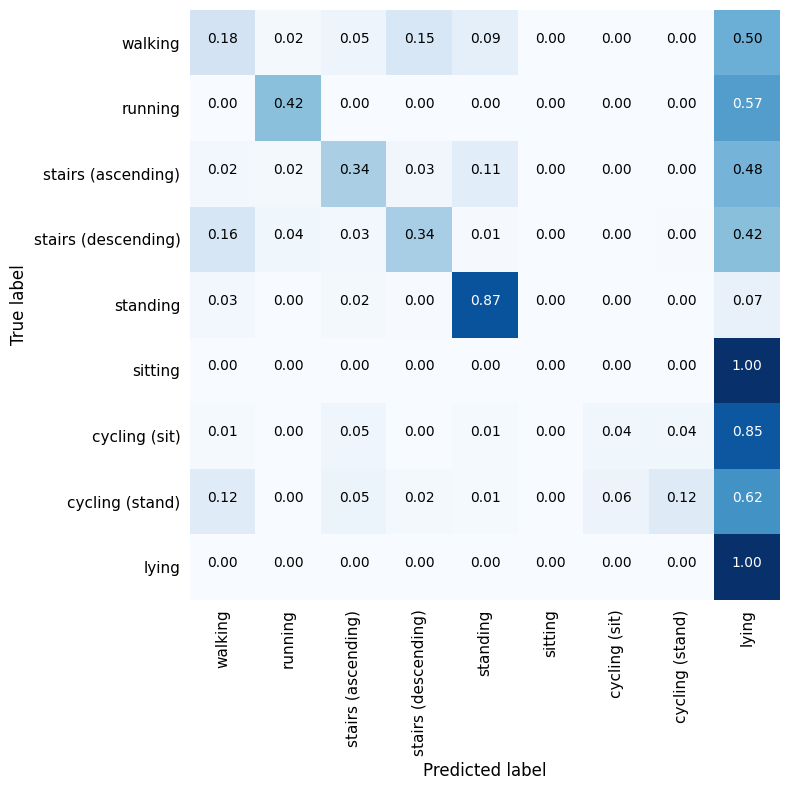

In [ ]:
  # mid model; 1 x class ; all of new
  # RMK run the section for creating exemplar set before executing this cell (change num of ex. x class)

  # create the train-reharsal set by concatenating new class training samples & exemplar set
  train_back = np.concatenate((back_samples[new_train], exemplar_set[:,:,0:3]), axis = 0)
  train_thigh = np.concatenate((thigh_samples[new_train], exemplar_set[:,:,3:6]), axis = 0)

  # create OHE of exemplars
  enc = OneHotEncoder(sparse=False)
  ohe_labels_exemp = enc.fit_transform(exemplar_lab.reshape(-1,1))
  # adapt them to size of training OHE & add them to OHE training
  z = np.zeros((exemplar_lab.shape[0],1))
  z = np.concatenate((ohe_labels_exemp, z), axis = 1)
  ohe_train = np.concatenate((ohe_labels_new_train,z), axis=0)

  #prepare confusion matrix
  cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]
  # get validation data
  train_rehearse, val_tr, ohe_train, ohe_val_tr = train_test_split(range(len(ohe_train)), ohe_train, test_size=0.1)


  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=["accuracy"]
  )

  # Train on new data with cross-entropy loss for new classes
  print("\nTraining on new data with cross-entropy loss...")
  history = model.fit(
      x=[train_back[train_rehearse], train_thigh[train_rehearse]],
      y=ohe_train,
      batch_size=batch_size,
      epochs=n_epochs,
      validation_data=([train_back[val_tr], train_thigh[val_tr]], ohe_val_tr),
      callbacks=[early_stopping]
  )

  # Save the model
  print("\nSaving model...")
  model.save(f"{project_path}/iCaRL_1mid")


print("\nPredicting...") # using the classification layer
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1) # add zero after the OHE of old test as it was OHE x 8 classes, now we have 9 (-> )
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)

print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Training on new data with cross-entropy loss...
Epoch 1/80
49/49 [==============================] - 5s 33ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 3.2495e-04 - val_accuracy: 1.0000
Epoch 2/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 5.4260e-06 - val_accuracy: 1.0000
Epoch 3/80
49/49 [==============================] - 1s 18ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 3.6811e-06 - val_accuracy: 1.0000
Epoch 4/80
49/49 [==============================] - 0s 9ms/step - loss: 3.7621e-04 - accuracy: 1.0000 - val_loss: 1.9858e-06 - val_accuracy: 1.0000
Epoch 5/80
49/49 [==============================] - 1s 10ms/step - loss: 1.4385e-04 - accuracy: 1.0000 - val_loss: 1.6460e-06 - val_accuracy: 1.0000
Epoch 6/80
49/49 [==============================] - 0s 9ms/step - loss: 6.3675e-05 - accuracy: 1.0000 - val_loss: 1.0608e-06 - val_accuracy: 1.0000
Epoch 7/80
49/49 [==============================] - 0s 10ms/step - loss

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

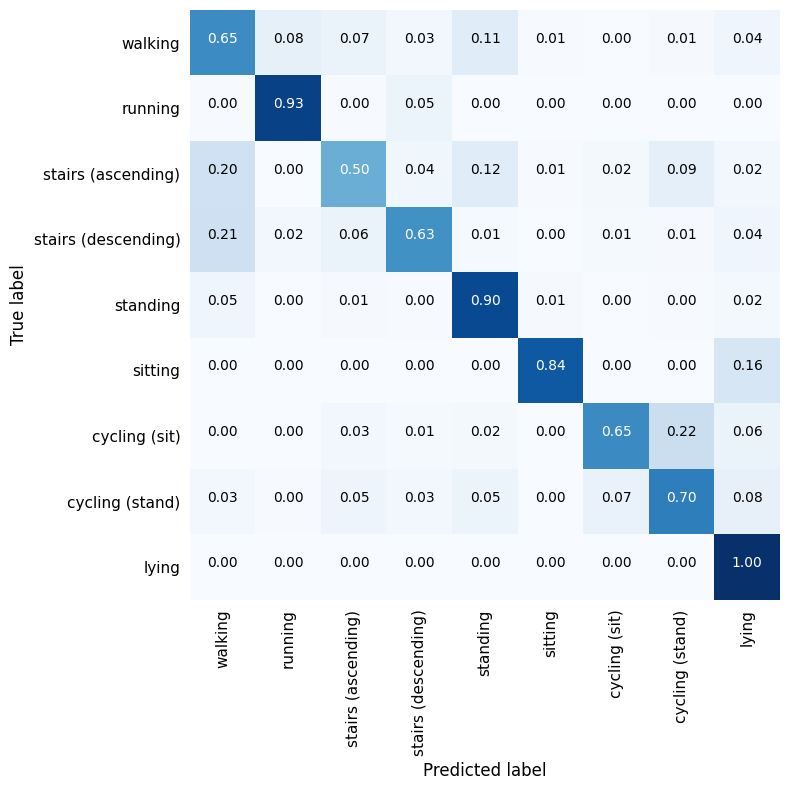

In [ ]:
  # mid model; 5 x class ; all of new
  # get training data & ohe labels
  enc = OneHotEncoder(sparse=False)
  ohe_labels_exemp = enc.fit_transform(exemplar_lab.reshape(-1,1))

  train_back = np.concatenate((back_samples[new_train], exemplar_set[:,:,0:3]), axis = 0)
  train_thigh = np.concatenate((thigh_samples[new_train], exemplar_set[:,:,3:6]), axis = 0)
  z = np.zeros((exemplar_lab.shape[0],1))
  z = np.concatenate((ohe_labels_exemp, z), axis = 1)
  ohe_train = np.concatenate((ohe_labels_new_train,z), axis=0)

  #prepare confusion matrix
  cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]
  # get validation data
  train_rehearse, val_tr, ohe_train, ohe_val_tr = train_test_split(range(len(ohe_train)), ohe_train, test_size=0.1)


  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=["accuracy"]
  )

  # Train on new data with cross-entropy loss for new classes
  print("\nTraining on new data with cross-entropy loss...")
  history = model.fit(
      x=[train_back[train_rehearse], train_thigh[train_rehearse]],
      y=ohe_train,
      batch_size=batch_size,
      epochs=n_epochs,
      validation_data=([train_back[val_tr], train_thigh[val_tr]], ohe_val_tr),
      callbacks=[early_stopping]
  )

  # Save the model
  print("\nSaving model...")
  model.save(f"{project_path}/iCaRL_5mid")

print("\nPredicting...") # using the classification layer
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1) # add zero after the OHE of old test as it was OHE x 8 classes, now we have 9 (-> )
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)

print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)



Training on new data with cross-entropy loss...
Epoch 1/80
49/49 [==============================] - 4s 27ms/step - loss: 0.0839 - accuracy: 0.9759 - val_loss: 0.0088 - val_accuracy: 0.9942
Epoch 2/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.0041 - val_accuracy: 0.9985
Epoch 3/80
49/49 [==============================] - 1s 11ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.0038 - val_accuracy: 0.9985
Epoch 4/80
49/49 [==============================] - 1s 12ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 5/80
49/49 [==============================] - 1s 11ms/step - loss: 5.0460e-04 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 0.9985
Epoch 6/80
49/49 [==============================] - 1s 12ms/step - loss: 5.7392e-04 - accuracy: 0.9998 - val_loss: 0.0034 - val_accuracy: 0.9985
Epoch 7/80
49/49 [==============================] - 1s 11ms/step - loss: 3.2289e-04 - accuracy: 0

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

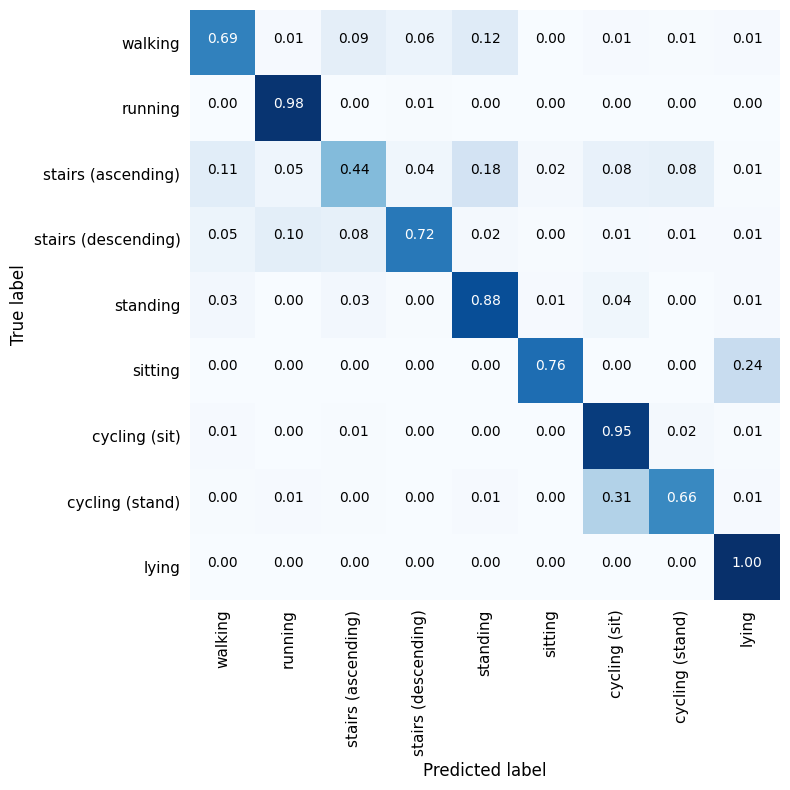

In [ ]:
  # mid model; 10 x class ; all of new
  # get training data & ohe labels
  enc = OneHotEncoder(sparse=False)
  ohe_labels_exemp = enc.fit_transform(exemplar_lab.reshape(-1,1))

  train_back = np.concatenate((back_samples[new_train], exemplar_set[:,:,0:3]), axis = 0)
  train_thigh = np.concatenate((thigh_samples[new_train], exemplar_set[:,:,3:6]), axis = 0)
  z = np.zeros((exemplar_lab.shape[0],1))
  z = np.concatenate((ohe_labels_exemp, z), axis = 1)
  ohe_train = np.concatenate((ohe_labels_new_train,z), axis=0)

  #prepare confusion matrix
  cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]
  # get validation data
  train_rehearse, val_tr, ohe_train, ohe_val_tr = train_test_split(range(len(ohe_train)), ohe_train, test_size=0.1)


  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=["accuracy"]
  )

  # Train on new data with cross-entropy loss for new classes
  print("\nTraining on new data with cross-entropy loss...")
  history = model.fit(
      x=[train_back[train_rehearse], train_thigh[train_rehearse]],
      y=ohe_train,
      batch_size=batch_size,
      epochs=n_epochs,
      validation_data=([train_back[val_tr], train_thigh[val_tr]], ohe_val_tr),
      callbacks=[early_stopping]
  )

  # Save the model
  print("\nSaving model...")
  model.save(f"{project_path}/iCaRL_10mid")

print("\nPredicting...") # using the classification layer
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1) # add zero after the OHE of old test as it was OHE x 8 classes, now we have 9 (-> )
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)

print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)


Training on new data with cross-entropy loss...
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


49/49 [==============================] - 6s 55ms/step - loss: 0.0111 - accuracy: 0.9968 - val_loss: 0.0074 - val_accuracy: 0.9971
Epoch 2/80
49/49 [==============================] - 1s 16ms/step - loss: 9.7973e-04 - accuracy: 0.9998 - val_loss: 0.0060 - val_accuracy: 0.9986
Epoch 3/80
49/49 [==============================] - 1s 16ms/step - loss: 6.1196e-04 - accuracy: 0.9998 - val_loss: 0.0065 - val_accuracy: 0.9986
Epoch 4/80
49/49 [==============================] - 1s 18ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0059 - val_accuracy: 0.9971
Epoch 5/80
49/49 [==============================] - 1s 18ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0107 - val_accuracy: 0.9957
Epoch 6/80
49/49 [==============================] - 1s 18ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0049 - val_accuracy: 0.9986
Epoch 7/80
49/49 [==============================] - 1s 13ms/step - loss: 6.0852e-05 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 0.9986
Epoch 8/80
4

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

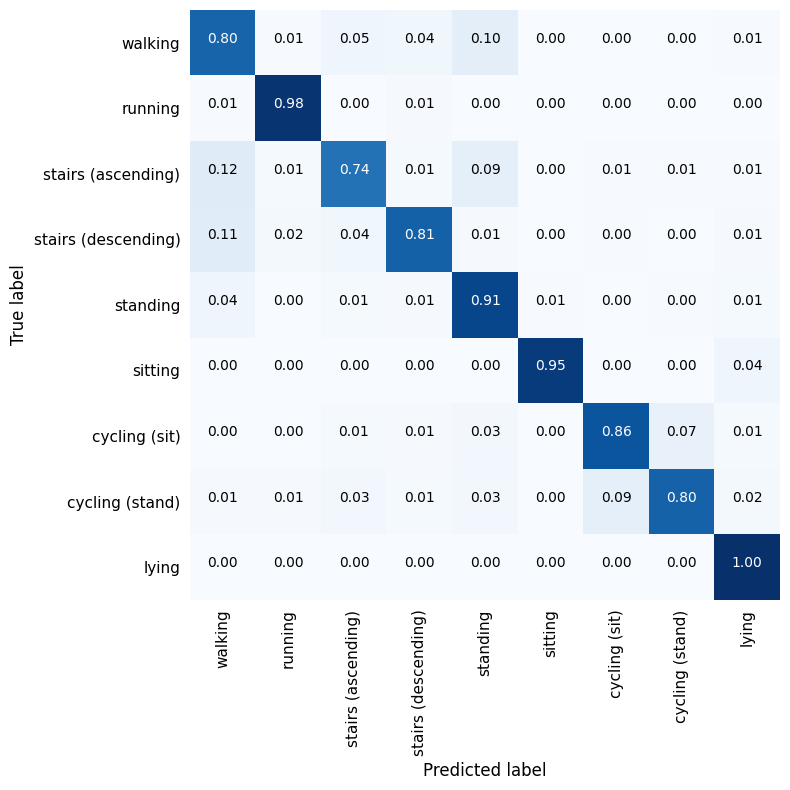

In [ ]:
  # mid model; 20 x class ; all of new
  # get training data & ohe labels
  enc = OneHotEncoder(sparse=False)
  ohe_labels_exemp = enc.fit_transform(exemplar_lab.reshape(-1,1))

  train_back = np.concatenate((back_samples[new_train], exemplar_set[:,:,0:3]), axis = 0)
  train_thigh = np.concatenate((thigh_samples[new_train], exemplar_set[:,:,3:6]), axis = 0)
  z = np.zeros((exemplar_lab.shape[0],1))
  z = np.concatenate((ohe_labels_exemp, z), axis = 1)
  ohe_train = np.concatenate((ohe_labels_new_train,z), axis=0)

  #prepare confusion matrix
  cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]
  # get validation data
  train_rehearse, val_tr, ohe_train, ohe_val_tr = train_test_split(range(len(ohe_train)), ohe_train, test_size=0.1)


  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=["accuracy"]
  )

  # Train on new data with cross-entropy loss for new classes
  print("\nTraining on new data with cross-entropy loss...")
  history = model.fit(
      x=[train_back[train_rehearse], train_thigh[train_rehearse]],
      y=ohe_train,
      batch_size=batch_size,
      epochs=n_epochs,
      validation_data=([train_back[val_tr], train_thigh[val_tr]], ohe_val_tr),
      callbacks=[early_stopping]
  )

  # Save the model
  print("\nSaving model...")
  model.save(f"{project_path}/iCaRL_20mid")

print("\nPredicting...") # using the classification layer
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1) # add zero after the OHE of old test as it was OHE x 8 classes, now we have 9 (-> )
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)

print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)



Training on new data with cross-entropy loss...
Epoch 1/80
51/51 [==============================] - 2s 16ms/step - loss: 0.0219 - accuracy: 0.9932 - val_loss: 0.0118 - val_accuracy: 0.9958
Epoch 2/80
51/51 [==============================] - 0s 9ms/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.0148 - val_accuracy: 0.9958
Epoch 3/80
51/51 [==============================] - 0s 8ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0164 - val_accuracy: 0.9958
Epoch 4/80
51/51 [==============================] - 0s 10ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0180 - val_accuracy: 0.9958
Epoch 5/80
51/51 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0173 - val_accuracy: 0.9958
Epoch 6/80
51/51 [==============================] - 0s 10ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0203 - val_accuracy: 0.9944

Saving model...

Predicting...
586/586 [==============================] - 2s 4ms/step

Classification Repor

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

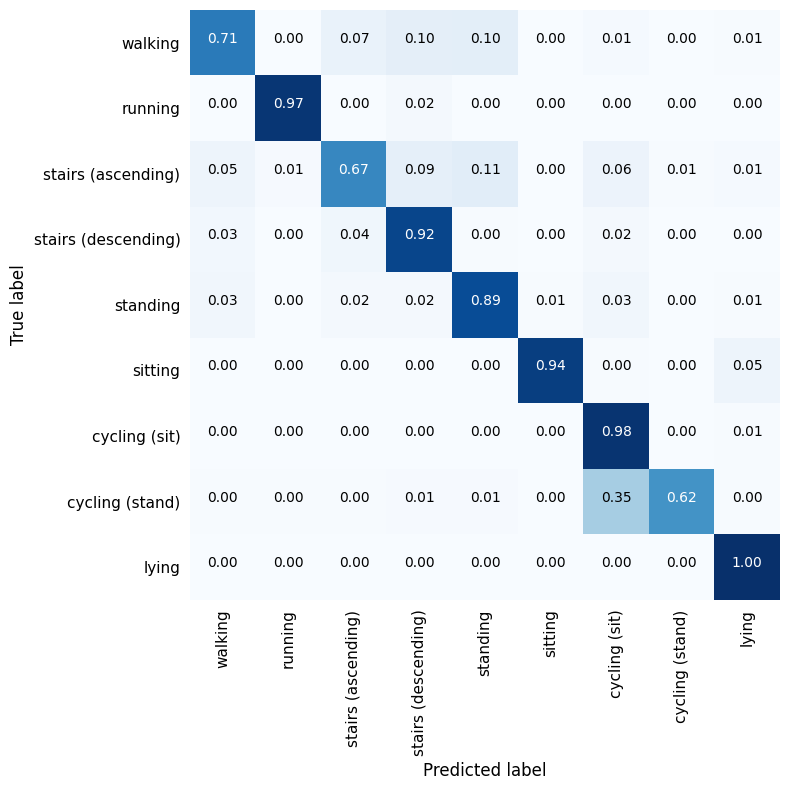

In [ ]:
  #  mid model; 50 x class ; all of new
  # get training data & ohe labels
  train_back = np.concatenate((back_samples[new_train], exemplar_set[:,:,0:3]), axis = 0)
  train_thigh = np.concatenate((thigh_samples[new_train], exemplar_set[:,:,3:6]), axis = 0)
  z = np.zeros((exemplar_lab.shape[0],1))
  z = np.concatenate((ohe_labels_exemp, z), axis = 1)
  ohe_train = np.concatenate((ohe_labels_new_train,z), axis=0)

  #prepare confusion matrix
  cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]
  # get validation data
  train_rehearse, val_tr, ohe_train, ohe_val_tr = train_test_split(range(len(ohe_train)), ohe_train, test_size=0.1)


  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=["accuracy"]
  )

  # Train on new data with cross-entropy loss for new classes
  print("\nTraining on new data with cross-entropy loss...")
  history = model.fit(
      x=[train_back[train_rehearse], train_thigh[train_rehearse]],
      y=ohe_train,
      batch_size=batch_size,
      epochs=n_epochs,
      validation_data=([train_back[val_tr], train_thigh[val_tr]], ohe_val_tr),
      callbacks=[early_stopping]
  )

  # Save the model
  print("\nSaving model...")
  model.save(f"{project_path}/iCaRL_50mid")

print("\nPredicting...") # using the classification layer
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1) # add zero after the OHE of old test as it was OHE x 8 classes, now we have 9 (-> )
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)

print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)

Here's a summary of the obtained results, which don't seem to be too far from the one obtained with random replay. In the following section I made a graph with both results for a clearer comparison.

Text(0.5, 1.0, 'Summary iCarl inspired replay with half-frozen model')

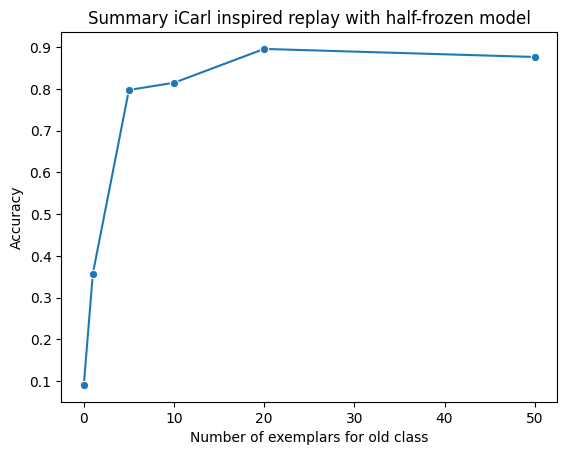

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
num_exempl = [0, 1, 5, 10, 20, 50]
accuracy_iCaRL = [0.0907, 0.3573, 0.7974, 0.8146,  0.8957, 0.8764] # i forgot to save files with accuracies -> copy&paste
                                                                   # from previous classific reports; i know it's not the best
#sns.scatterplot(x=num_exempl, y=accuracy_iCaRL)
sns.lineplot(x=num_exempl, y=accuracy_iCaRL, marker='o')
# Set plot labels and title
plt.xlabel('Number of exemplars for old class')
plt.ylabel('Accuracy')
plt.title('Summary iCarl inspired replay with half-frozen model')

<function matplotlib.pyplot.show(close=None, block=None)>

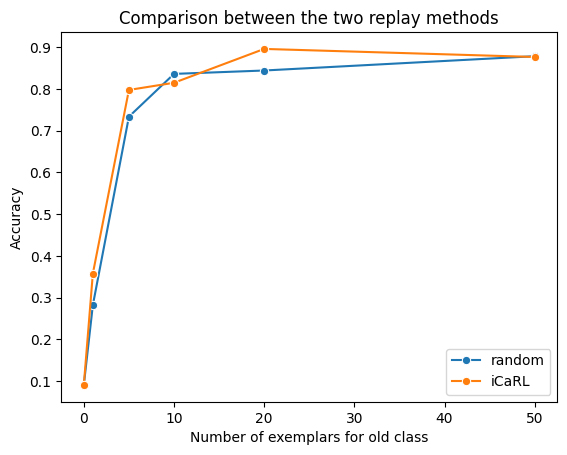

In [ ]:
# comparison
sns.lineplot(x=num_exempl, y=accuracy_random, marker='o', label = 'random')
sns.lineplot(x=num_exempl, y=accuracy_iCaRL, marker='o', label = 'iCaRL')

plt.xlabel('Number of exemplars for old class')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Comparison between the two replay methods')
plt.show

iCarl inspired exemplar selection gives much better results when 5 and 20 examples for class are put inside the rehearsal buffer but when increasing the buffer size there doesn't seem to be any advantage in implementing a more complex exemplar selection.

From what I have read in literature the "full" iCaRL algorithm, which uses a custom loss function and classification by a nearest-mean-of-exemplars rule, can give better results mostly thanks to the custom loss function which has a distillation term. The obtained results are in the same direction as they don't show huge improvements with respect to random replay.

In any case, using even as little as 5 examples for class for rehearsal incredibly increases the accuracy of the model adressing the problem of catastrophic forgetting.

##### Comparison of different type of models
Testing the difference between fully frozen, half frozen and trainable models.


Training on new data with cross-entropy loss...
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


49/49 [==============================] - 2s 17ms/step - loss: 0.6232 - accuracy: 0.7970 - val_loss: 0.0894 - val_accuracy: 0.9884
Epoch 2/80
49/49 [==============================] - 0s 8ms/step - loss: 0.0295 - accuracy: 0.9927 - val_loss: 0.0589 - val_accuracy: 0.9898
Epoch 3/80
49/49 [==============================] - 0s 8ms/step - loss: 0.0191 - accuracy: 0.9948 - val_loss: 0.0420 - val_accuracy: 0.9898
Epoch 4/80
49/49 [==============================] - 0s 9ms/step - loss: 0.0142 - accuracy: 0.9961 - val_loss: 0.0337 - val_accuracy: 0.9913
Epoch 5/80
49/49 [==============================] - 0s 10ms/step - loss: 0.0106 - accuracy: 0.9973 - val_loss: 0.0295 - val_accuracy: 0.9942
Epoch 6/80
49/49 [==============================] - 1s 16ms/step - loss: 0.0085 - accuracy: 0.9982 - val_loss: 0.0273 - val_accuracy: 0.9942
Epoch 7/80
49/49 [==============================] - 1s 17ms/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 0.0248 - val_accuracy: 0.9942
Epoch 8/80
49/49 [=========

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

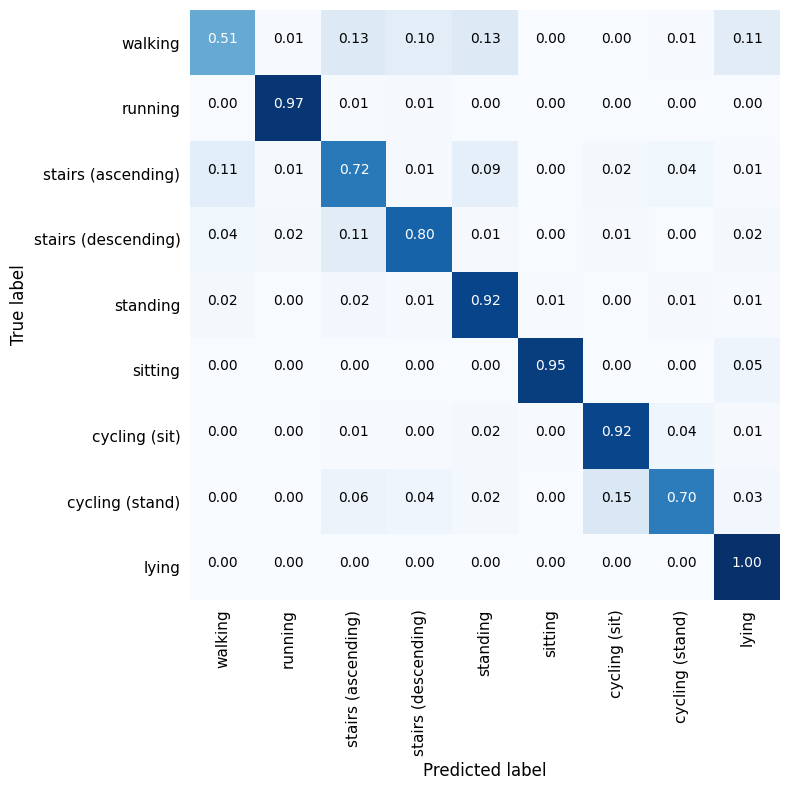

In [ ]:
  # frozen model; 10 x class ; all of new
  # get training data & ohe labels
  model = new_classifier(old_model, n_freeze = 14)

  enc = OneHotEncoder(sparse=False)
  ohe_labels_exemp = enc.fit_transform(exemplar_lab.reshape(-1,1))

  train_back = np.concatenate((back_samples[new_train], exemplar_set[:,:,0:3]), axis = 0)
  train_thigh = np.concatenate((thigh_samples[new_train], exemplar_set[:,:,3:6]), axis = 0)
  z = np.zeros((exemplar_lab.shape[0],1))
  z = np.concatenate((ohe_labels_exemp, z), axis = 1)
  ohe_train = np.concatenate((ohe_labels_new_train,z), axis=0)

  #prepare confusion matrix
  cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]
  # get validation data
  train_rehearse, val_tr, ohe_train, ohe_val_tr = train_test_split(range(len(ohe_train)), ohe_train, test_size=0.1)


  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=["accuracy"]
  )

  # Train on new data with cross-entropy loss for new classes
  print("\nTraining on new data with cross-entropy loss...")
  history = model.fit(
      x=[train_back[train_rehearse], train_thigh[train_rehearse]],
      y=ohe_train,
      batch_size=batch_size,
      epochs=n_epochs,
      validation_data=([train_back[val_tr], train_thigh[val_tr]], ohe_val_tr),
      callbacks=[early_stopping]
  )

  # Save the model
  print("\nSaving model...")
  model.save(f"{project_path}/iCaRL_10full")

overall_accuracy = accuracy_score(y_targets, y_preds)
with open('/content/drive/MyDrive/ColabData/AmID/replay/iCaRL_10_full_acc.pkl', 'wb') as file:
    pickle.dump(overall_accuracy, file)

print("\nPredicting...") # using the classification layer
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1) # add zero after the OHE of old test as it was OHE x 8 classes, now we have 9 (-> )
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)

print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Training on new data with cross-entropy loss...
Epoch 1/80
49/49 [==============================] - 10s 33ms/step - loss: 0.9875 - accuracy: 0.8543 - val_loss: 0.0606 - val_accuracy: 0.9869
Epoch 2/80
49/49 [==============================] - 1s 15ms/step - loss: 0.0108 - accuracy: 0.9964 - val_loss: 0.0484 - val_accuracy: 0.9898
Epoch 3/80
49/49 [==============================] - 1s 16ms/step - loss: 0.0038 - accuracy: 0.9984 - val_loss: 0.0350 - val_accuracy: 0.9898
Epoch 4/80
49/49 [==============================] - 1s 15ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0364 - val_accuracy: 0.9927
Epoch 5/80
49/49 [==============================] - 1s 16ms/step - loss: 6.3612e-04 - accuracy: 0.9998 - val_loss: 0.0358 - val_accuracy: 0.9898
Epoch 6/80
49/49 [==============================] - 1s 15ms/step - loss: 3.4936e-04 - accuracy: 1.0000 - val_loss: 0.0383 - val_accuracy: 0.9898
Epoch 7/80
49/49 [==============================] - 1s 16ms/step - loss: 3.4114e-04 - accuracy: 

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

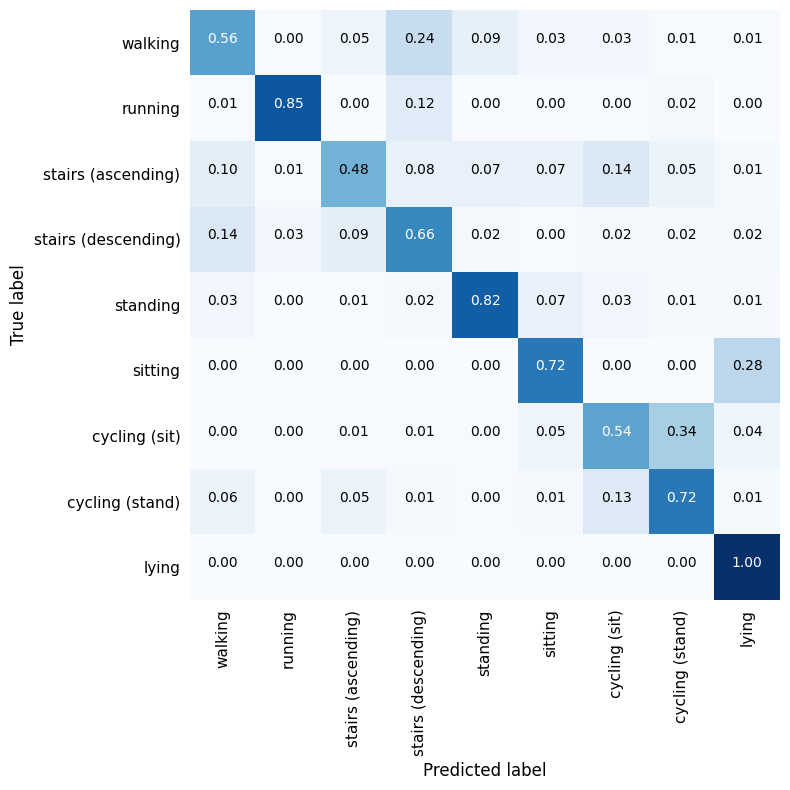

In [ ]:
  # trainable model; 10 x class ; all of new
  # get training data & ohe labels
  model = new_classifier(old_model, n_freeze = 0)

  enc = OneHotEncoder(sparse=False)
  ohe_labels_exemp = enc.fit_transform(exemplar_lab.reshape(-1,1))

  train_back = np.concatenate((back_samples[new_train], exemplar_set[:,:,0:3]), axis = 0)
  train_thigh = np.concatenate((thigh_samples[new_train], exemplar_set[:,:,3:6]), axis = 0)
  z = np.zeros((exemplar_lab.shape[0],1))
  z = np.concatenate((ohe_labels_exemp, z), axis = 1)
  ohe_train = np.concatenate((ohe_labels_new_train,z), axis=0)

  #prepare confusion matrix
  cm = [np.zeros([len(classes_names)]) for _ in range(len(classes_names))]
  # get validation data
  train_rehearse, val_tr, ohe_train, ohe_val_tr = train_test_split(range(len(ohe_train)), ohe_train, test_size=0.1)


  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=["accuracy"]
  )

  # Train on new data with cross-entropy loss for new classes
  print("\nTraining on new data with cross-entropy loss...")
  history = model.fit(
      x=[train_back[train_rehearse], train_thigh[train_rehearse]],
      y=ohe_train,
      batch_size=batch_size,
      epochs=n_epochs,
      validation_data=([train_back[val_tr], train_thigh[val_tr]], ohe_val_tr),
      callbacks=[early_stopping]
  )

  # Save the model
  print("\nSaving model...")
  model.save(f"{project_path}/iCaRL_10free")

overall_accuracy = accuracy_score(y_targets, y_preds)
with open('/content/drive/MyDrive/ColabData/AmID/replay/iCaRL_10_free_acc.pkl', 'wb') as file:
    pickle.dump(overall_accuracy, file)

print("\nPredicting...") # using the classification layer
y_preds = model.predict([back_samples[np.concatenate((old_test, new_test), axis=0)], thigh_samples[np.concatenate((old_test, new_test), axis=0)]])

y_preds = np.argmax(y_preds, axis=1)
z = np.zeros((old_test.shape[0],1))
z = np.concatenate((ohe_labels_old_test, z), axis = 1) # add zero after the OHE of old test as it was OHE x 8 classes, now we have 9 (-> )
z = np.concatenate((z, ohe_labels_new_test), axis=0)

y_targets = np.argmax(z, axis=1)

print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_names[el])
for el in y_targets: s_targets.append(classes_names[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes_names)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_names)

Text(0.5, 1.0, 'Summary 10 exemplars iCaRL inspired replay')

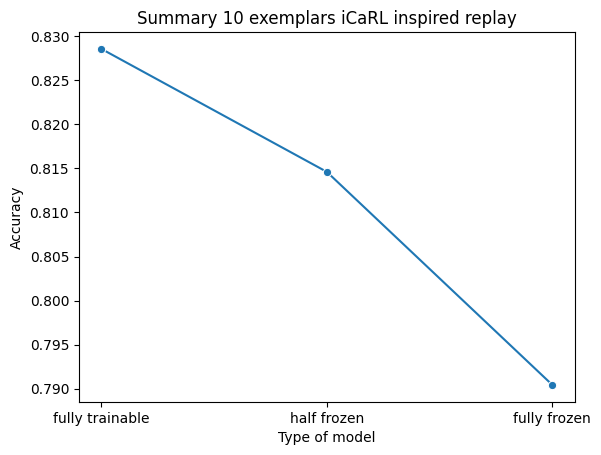

In [ ]:
type_of_model = ['free', 'mid', 'full']
accuracy_icarl_m = np.zeros((1, len(type_of_model)))[0]
accuracy_icarl_m[1] = 0.8146
base_path = '/content/drive/MyDrive/ColabData/AmID/replay/'

for idx in[0,2]:
    file_path = os.path.join(base_path, f'iCaRL_10_{type_of_model[idx]}_acc.pkl')

    # Check if the file exists before attempting to load it
    if os.path.exists(file_path):
        with open(file_path, 'rb') as file:
            accuracy_icarl_m[idx]= pickle.load(file)

#sns.scatterplot(x=num_exempl, y=accuracy_iCaRL)
sns.lineplot(x=['fully trainable', 'half frozen', 'fully frozen'], y=accuracy_icarl_m, marker='o')
# Set plot labels and title
plt.xlabel('Type of model')
plt.ylabel('Accuracy')
plt.title('Summary 10 exemplars iCaRL inspired replay')

In this case the difference of performance is much bigger with respect to what was observed for random replay. Here the fully trainable model is the one with highest overall accuracy but the three metrics (precision,    recall,  f1-score) are a bit more balanced for the half frozen model, so that's part of the reason why all the previous studies were done on such model.

<function matplotlib.pyplot.show(close=None, block=None)>

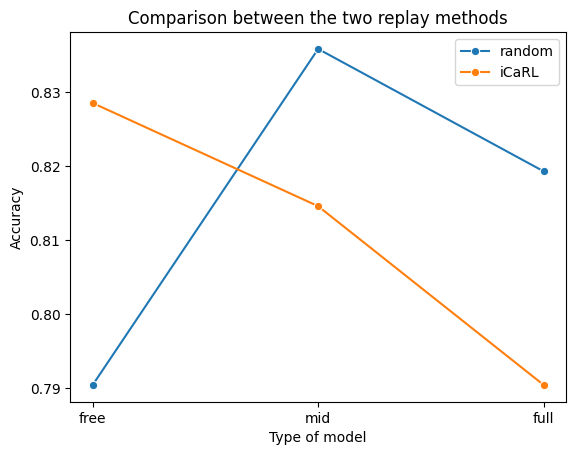

In [ ]:
# comparison
sns.lineplot(x=type_of_model, y=accuracy_random_m, marker='o', label = 'random')
sns.lineplot(x=type_of_model, y=accuracy_icarl_m, marker='o', label = 'iCaRL')

plt.xlabel('Type of model')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Comparison between the two replay methods')
plt.show